In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/1017 RDS/project')

In [3]:
!ls

 1017_RDS_draft.pdf		 Aif_Metric.ipynb	  prompt.gdoc
'1.1 EDA.ipynb'			 insurance.csv		  prompt.pdf
'1.2 ADS Implementation.ipynb'	'project proposal.gdoc'


# Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
!pip install numba==0.48
!pip install aif360==0.2.2
!python -m pip install BlackBoxAuditing
!pip install tensorflow==1.13.1
!pip install category_encoders

In [6]:
# import all necessary packages
import numpy as np
np.random.seed(0)

from tqdm import tqdm
from math import sqrt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score, mean_squared_error, \
      confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, average_precision_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing.meta_fair_classifier import MetaFairClassifier
import BlackBoxAuditing
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import CompasDataset, AdultDataset, StandardDataset, BankDataset, GermanDataset, BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification
import seaborn as sns

import tensorflow as tf
print(tf.__version__)

from IPython.display import Markdown, display

import seaborn as sns

import json
from collections import OrderedDict

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


In [7]:
%matplotlib inline

# load data

In [8]:
df = pd.read_csv('insurance.csv')
df.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [9]:
# add additional binary label
df["exp_bin"] = np.where(df["expenses"] > 10000 , 1, 0)

# Repeat ADS - Random Forest

The ADS dropped the feature `region` for reasons unexplained. It was not due to missing data.

In [10]:
df_model = df.copy()
df_model.drop(["region", "exp_bin"], axis=1, inplace=True) 
df_model.head()

,age,sex,bmi,children,smoker,expenses
0,19,female,27.9,0,yes,16884.92
1,18,male,33.8,1,no,1725.55
2,28,male,33.0,3,no,4449.46
3,33,male,22.7,0,no,21984.47
4,32,male,28.9,0,no,3866.86


In [11]:
# Changing binary categories to 1s and 0s
df_model['sex'] = df_model['sex'].map(lambda s :1  if s == 'female' else 0)
df_model['smoker'] = df_model['smoker'].map(lambda s :1  if s == 'yes' else 0)
df_model.rename(columns = {'expenses':'charges'}, inplace = True) 
df_model.head()

,age,sex,bmi,children,smoker,charges
0,19,1,27.9,0,1,16884.92
1,18,0,33.8,1,0,1725.55
2,28,0,33.0,3,0,4449.46
3,33,0,22.7,0,0,21984.47
4,32,0,28.9,0,0,3866.86


In [12]:
X = df_model.drop(['charges'], axis = 1).copy()
y = df_model['charges'].copy()
print('Shape of X: ', X.shape)
print('Shape of y: ', y.shape)


Shape of X:  (1338, 5)
Shape of y:  (1338,)


In [13]:
# split data in the same way he did
X_train_og, X_test_og, y_train, y_test = train_test_split(X, y, random_state = 0)

# Normalize the data
# now our features all have mean 0 and std 1
sc = StandardScaler()
X_train = sc.fit_transform(X_train_og)
  # np.arr lost track of indices
X_test = sc.transform(X_test_og)
  # np.arr lost track of indices

In [14]:
X_test.shape
  # 335 samples, 5 features, each features is standardized to have mean 0 and std 1

(335, 5)

In [15]:
X_test_df = pd.DataFrame(data=X_test,
                         columns=['age','sex','bmi','children','smoker'])
X_test_df

,age,sex,bmi,children,smoker
0,0.908319,-1.015069,-0.083753,-0.063607,-0.503736
1,0.552526,0.985155,-0.212151,-0.063607,-0.503736
2,0.623684,-1.015069,1.585420,0.764931,1.985167
3,1.548746,-1.015069,1.232325,-0.892144,-0.503736
4,0.837160,0.985155,-2.025771,-0.892144,-0.503736
...,...,...,...,...,...
330,1.264112,0.985155,0.574286,0.764931,-0.503736
331,-0.728329,-1.015069,0.221192,0.764931,-0.503736
332,0.837160,-1.015069,-0.115853,-0.063607,-0.503736
333,-1.155281,-1.015069,1.023679,1.593468,-0.503736


In [16]:
# random forest same as he did 

random_forest_reg = RandomForestRegressor(n_estimators=400, max_depth=5, random_state=13)  
random_forest_reg.fit(X_train, y_train) 

y_pred_model_train = random_forest_reg.predict(X_train)
y_pred_model_test = random_forest_reg.predict(X_test)

# RMSE for regression
RMSE_model_train = sqrt(mean_squared_error(y_train, y_pred_model_train))
print("RMSE for Training Data: ", RMSE_model_train)

RMSE_model_test = sqrt(mean_squared_error(y_test, y_pred_model_test))
print("RMSE for Testing Data: ", RMSE_model_test)


# for regression, we use r2_score as accuracy measure, which is 1 - (RSS/TSS)
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get 0.0
r2_model_train = r2_score(y_train, y_pred_model_train)
print("Training Regression Accuracy: ", r2_model_train)

r2_model_test = r2_score(y_test, y_pred_model_test)
print("Testing Regression Accuracy: ", r2_model_test)

# for binary results, we use accuracy_score as accuracy measure
# which is (# of same label)/# of all labels
acc_model_train = accuracy_score((y_train > 10000) * 1, (y_pred_model_train > 10000) * 1)
  # convert both ys to binary labels using the same critera
print("Training Binary Accuracy: ", acc_model_train)

acc_model_test = accuracy_score((y_test > 10000) * 1, (y_pred_model_test > 10000) * 1)
  # convert both ys to binary labels using the same critera
print("Testing Binary Accuracy: ", acc_model_test)


RMSE for Training Data:  4170.979793736701
RMSE for Testing Data:  4028.43567685455
Training Regression Accuracy:  0.878251099532176
Testing Regression Accuracy:  0.8969203533577584
Training Binary Accuracy:  0.8743768693918246
Testing Binary Accuracy:  0.8716417910447761


we have reached the same accuracy and performance as the proposed ADS.

## merge restuls back with the original data for fairness metrics

In [17]:
df_1 = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred_model_train})
  # preserves all original indices of y_train
df_2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_model_test})
  # preserves all original indices of y_test
print(df_1.shape)
print(df_2.shape)

(1003, 2)
(335, 2)


In [18]:
df_train = df_1.merge(df, how='left',left_index=True, right_index=True, copy=True)
  # preserves and matches all original indices of df_1, just with additional feature information
df_test = df_2.merge(df, how='left',left_index=True, right_index=True, copy=True)
  # preserves and matches all original indices of df_2, just with additional feature information

# make sure all records matched correctly
assert np.all(df_test['expenses'] == df_test['Actual'])
assert np.all(df_train['expenses'] == df_train['Actual'])

In [19]:
# remove redundant columns
df_test.drop("Actual", axis=1, inplace=True)
df_train.drop("Actual", axis=1, inplace=True)

# rename columns
df_test.rename(columns = {'Predicted':'predicted_expenses'}, inplace = True) 
df_train.rename(columns = {'Predicted':'predicted_expenses'}, inplace = True) 

# add predicted binary labels
df_test["predicted_exp_bin"] = np.where(df_test["predicted_expenses"] > 10000 , 1, 0)
df_train["predicted_exp_bin"] = np.where(df_train["predicted_expenses"] > 10000 , 1, 0)

In [20]:
# Encoded test and train for aif360 later
df_test_encoded = df_test.copy()
df_train_encoded = df_train.copy()
df_test_encoded['sex'] = df_test_encoded['sex'].map(lambda s :1  if s == 'female' else 0)
df_test_encoded['smoker'] = df_test_encoded['smoker'].map(lambda s :1  if s == 'yes' else 0)
df_train_encoded['sex'] = df_train_encoded['sex'].map(lambda s :1  if s == 'female' else 0)
df_train_encoded['smoker'] = df_train_encoded['smoker'].map(lambda s :1  if s == 'yes' else 0)

import category_encoders as ce
encoder= ce.OrdinalEncoder(cols=['region'],return_df=True,
                           mapping=[{'col':'region',
                           'mapping':{'southwest':0,'southeast':1,'northwest':2,'northeast':3}}])

df_test_encoded = encoder.fit_transform(df_test_encoded)
df_train_encoded = encoder.fit_transform(df_train_encoded)

df_train_encoded_actual = df_train_encoded.drop(['predicted_exp_bin'], axis = 1)
df_train_encoded_pred = df_train_encoded.drop(['exp_bin'], axis = 1)
df_train_encoded_pred = df_train_encoded_pred.rename(columns={"predicted_exp_bin": "exp_bin"})

df_test_encoded_actual = df_test_encoded.drop(['predicted_exp_bin'], axis = 1)
df_test_encoded_pred = df_test_encoded.drop(['exp_bin'], axis = 1 )
df_test_encoded_pred = df_test_encoded_pred.rename(columns={"predicted_exp_bin": "exp_bin"})


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


# accuracy across subgroups

## overall

In [21]:
# overall Accuracies
# RMSE for regression
RMSE_model_train = sqrt(mean_squared_error(y_train, y_pred_model_train))
print("RMSE for Training Data: ", RMSE_model_train)

RMSE_model_test = sqrt(mean_squared_error(y_test, y_pred_model_test))
print("RMSE for Testing Data: ", RMSE_model_test)


# for regression, we use r2_score as accuracy measure, which is 1 - (RSS/TSS)
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get 0.0
r2_model_train = r2_score(y_train, y_pred_model_train)
print("Training Regression Accuracy: ", r2_model_train)

r2_model_test = r2_score(y_test, y_pred_model_test)
print("Testing Regression Accuracy: ", r2_model_test)

# for binary results, we use accuracy_score as accuracy measure
# which is (# of same label)/# of all labels
acc_model_train = accuracy_score((y_train > 10000) * 1, (y_pred_model_train > 10000) * 1)
  # convert both ys to binary labels using the same critera
print("Training Binary Accuracy: ", acc_model_train)

acc_model_test = accuracy_score((y_test > 10000) * 1, (y_pred_model_test > 10000) * 1)
  # convert both ys to binary labels using the same critera
print("Testing Binary Accuracy: ", acc_model_test)

RMSE for Training Data:  4170.979793736701
RMSE for Testing Data:  4028.43567685455
Training Regression Accuracy:  0.878251099532176
Testing Regression Accuracy:  0.8969203533577584
Training Binary Accuracy:  0.8743768693918246
Testing Binary Accuracy:  0.8716417910447761


In [22]:
# allocate some spaces for storing and plotting later
train_reg_acc_priv = []
train_reg_acc_unpriv = []
test_reg_acc_priv = []
test_reg_acc_unpriv = []

train_bin_acc_priv = []
train_bin_acc_unpriv = []
test_bin_acc_priv = []
test_bin_acc_unpriv = []

## age

In [23]:
df['age'].describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

since age has both mean and median of around 39, we will use this as our cutoff point.

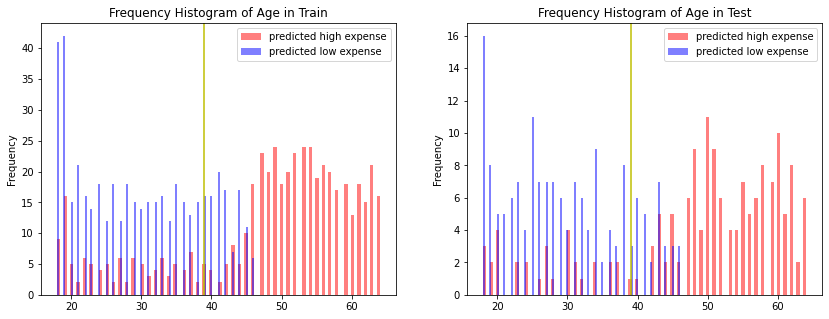

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

x1 = df_train.loc[df_train.predicted_exp_bin==1, 'age']
x2 = df_train.loc[df_train.predicted_exp_bin==0, 'age']
kwargs = dict(alpha=0.5, bins=100)
ax[0].hist(x1, **kwargs, color='r', label='predicted high expense')
ax[0].hist(x2, **kwargs, color='b', label='predicted low expense')
ax[0].set(title='Frequency Histogram of Age in Train', ylabel='Frequency')
ax[0].axvline(x=39,color='y')
ax[0].legend()

x1 = df_test.loc[df_test.predicted_exp_bin==1, 'age']
x2 = df_test.loc[df_test.predicted_exp_bin==0, 'age']
kwargs = dict(alpha=0.5, bins=100)
ax[1].hist(x1, **kwargs, color='r', label='predicted high expense')
ax[1].hist(x2, **kwargs, color='b', label='predicted low expense')
ax[1].set(title='Frequency Histogram of Age in Test', ylabel='Frequency')
ax[1].axvline(x=39,color='y')
ax[1].legend()

In [28]:
# split into priv and unpriv for train and test
df_train_priv = df_train[df_train['age']<=39].copy()
df_train_unpriv = df_train[df_train['age']>39].copy()

df_test_priv = df_test[df_test['age']<=39].copy()
df_test_unpriv = df_test[df_test['age']>39].copy()

print(df_train_priv.shape, df_train_unpriv.shape)
print(df_test_priv.shape, df_test_unpriv.shape)

(503, 10) (500, 10)
(171, 10) (164, 10)


In [29]:
# Regression accuracy

# train
train_priv_r2 = r2_score(df_train_priv['expenses'], 
                         df_train_priv['predicted_expenses'])
train_reg_acc_priv.append(train_priv_r2)
print("Training Regression Accuracy for privileged group: ", train_priv_r2)

train_unpriv_r2 = r2_score(df_train_unpriv['expenses'], 
                           df_train_unpriv['predicted_expenses'])
train_reg_acc_unpriv.append(train_unpriv_r2)
print("Training Regression Accuracy for unprivileged group: ", train_unpriv_r2)

# test
test_priv_r2 = r2_score(df_test_priv['expenses'], 
                        df_test_priv['predicted_expenses'])
test_reg_acc_priv.append(test_priv_r2)
print("Testing Regression Accuracy for privileged group: ", test_priv_r2)

test_unpriv_r2 = r2_score(df_test_unpriv['expenses'], 
                          df_test_unpriv['predicted_expenses'])
test_reg_acc_unpriv.append(test_unpriv_r2)
print("Tesing Regression Accuracy for unprivileged group: ", test_unpriv_r2)

Training Regression Accuracy for privileged group:  0.8805885771999397
Training Regression Accuracy for unprivileged group:  0.8604069596217654
Testing Regression Accuracy for privileged group:  0.8536913064636402
Tesing Regression Accuracy for unprivileged group:  0.9086705395231626


In [30]:
# Binary accuracy

# train
train_priv_acc = accuracy_score(df_train_priv['exp_bin'], 
                                df_train_priv['predicted_exp_bin'])
train_bin_acc_priv.append(train_priv_acc)
print("Training Binary Accuracy for privileged group: ", train_priv_acc)

train_unpriv_acc = accuracy_score(df_train_unpriv['exp_bin'], 
                                df_train_unpriv['predicted_exp_bin'])
train_bin_acc_unpriv.append(train_unpriv_acc)
print("Training Binary Accuracy for unprivileged group: ", train_unpriv_acc)

# test
test_priv_acc = accuracy_score(df_test_priv['exp_bin'], 
                               df_test_priv['predicted_exp_bin'])
test_bin_acc_priv.append(test_priv_acc)
print("Testing Binary Accuracy for privileged group: ", test_priv_acc)

test_unpriv_acc = accuracy_score(df_test_unpriv['exp_bin'], 
                                 df_test_unpriv['predicted_exp_bin'])
test_bin_acc_unpriv.append(test_unpriv_acc)
print("Testing Binary Accuracy for unprivileged group: ", test_unpriv_acc)

Training Binary Accuracy for privileged group:  0.9284294234592445
Training Binary Accuracy for unprivileged group:  0.82
Testing Binary Accuracy for privileged group:  0.9298245614035088
Testing Binary Accuracy for unprivileged group:  0.8109756097560976


## bmi

In [31]:
df['bmi'].describe()

count    1338.000000
mean       30.665471
std         6.098382
min        16.000000
25%        26.300000
50%        30.400000
75%        34.700000
max        53.100000
Name: bmi, dtype: float64

since bmi has both mean and median of around 30, we will use this as our cutoff point.

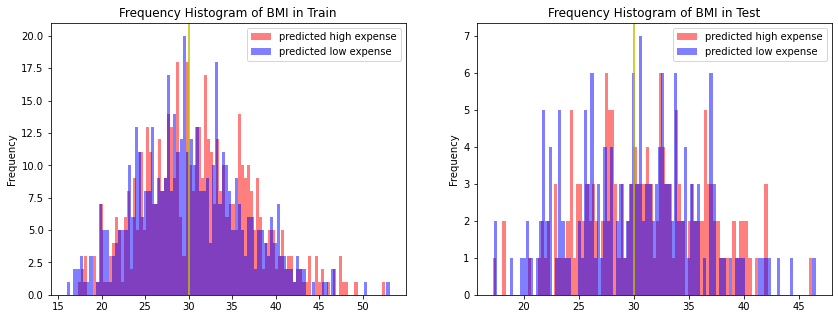

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

x1 = df_train.loc[df_train.predicted_exp_bin==1, 'bmi']
x2 = df_train.loc[df_train.predicted_exp_bin==0, 'bmi']
kwargs = dict(alpha=0.5, bins=100)
ax[0].hist(x1, **kwargs, color='r', label='predicted high expense')
ax[0].hist(x2, **kwargs, color='b', label='predicted low expense')
ax[0].set(title='Frequency Histogram of BMI in Train', ylabel='Frequency')
ax[0].axvline(x=30,color='y')
ax[0].legend()

x1 = df_test.loc[df_test.predicted_exp_bin==1, 'bmi']
x2 = df_test.loc[df_test.predicted_exp_bin==0, 'bmi']
kwargs = dict(alpha=0.5, bins=100)
ax[1].hist(x1, **kwargs, color='r', label='predicted high expense')
ax[1].hist(x2, **kwargs, color='b', label='predicted low expense')
ax[1].set(title='Frequency Histogram of BMI in Test', ylabel='Frequency')
ax[1].axvline(x=30,color='y')
ax[1].legend()

In [33]:
# split into priv and unpriv for train and test
df_train_priv = df_train[df_train['bmi']<=30].copy()
df_train_unpriv = df_train[df_train['bmi']>30].copy()

df_test_priv = df_test[df_test['bmi']<=30].copy()
df_test_unpriv = df_test[df_test['bmi']>30].copy()

print(df_train_priv.shape, df_train_unpriv.shape)
print(df_test_priv.shape, df_test_unpriv.shape)

(487, 10) (516, 10)
(153, 10) (182, 10)


In [34]:
# Regression accuracy

# train
train_priv_r2 = r2_score(df_train_priv['expenses'], 
                         df_train_priv['predicted_expenses'])
train_reg_acc_priv.append(train_priv_r2)
print("Training Regression Accuracy for privileged group: ", train_priv_r2)

train_unpriv_r2 = r2_score(df_train_unpriv['expenses'], 
                           df_train_unpriv['predicted_expenses'])
train_reg_acc_unpriv.append(train_unpriv_r2)
print("Training Regression Accuracy for unprivileged group: ", train_unpriv_r2)

# test
test_priv_r2 = r2_score(df_test_priv['expenses'], 
                        df_test_priv['predicted_expenses'])
test_reg_acc_priv.append(test_priv_r2)
print("Testing Regression Accuracy for privileged group: ", test_priv_r2)

test_unpriv_r2 = r2_score(df_test_unpriv['expenses'], 
                          df_test_unpriv['predicted_expenses'])
test_reg_acc_unpriv.append(test_unpriv_r2)
print("Tesing Regression Accuracy for unprivileged group: ", test_unpriv_r2)

Training Regression Accuracy for privileged group:  0.7414187541186275
Training Regression Accuracy for unprivileged group:  0.9127083158449153
Testing Regression Accuracy for privileged group:  0.6815073829321083
Tesing Regression Accuracy for unprivileged group:  0.9327366461807857


In [35]:
# Binary accuracy

# train
train_priv_acc = accuracy_score(df_train_priv['exp_bin'], 
                                df_train_priv['predicted_exp_bin'])
train_bin_acc_priv.append(train_priv_acc)
print("Training Binary Accuracy for privileged group: ", train_priv_acc)

train_unpriv_acc = accuracy_score(df_train_unpriv['exp_bin'], 
                                df_train_unpriv['predicted_exp_bin'])
train_bin_acc_unpriv.append(train_unpriv_acc)
print("Training Binary Accuracy for unprivileged group: ", train_unpriv_acc)

# test
test_priv_acc = accuracy_score(df_test_priv['exp_bin'], 
                               df_test_priv['predicted_exp_bin'])
test_bin_acc_priv.append(test_priv_acc)
print("Testing Binary Accuracy for privileged group: ", test_priv_acc)

test_unpriv_acc = accuracy_score(df_test_unpriv['exp_bin'], 
                                 df_test_unpriv['predicted_exp_bin'])
test_bin_acc_unpriv.append(test_unpriv_acc)
print("Testing Binary Accuracy for unprivileged group: ", test_unpriv_acc)

Training Binary Accuracy for privileged group:  0.8850102669404517
Training Binary Accuracy for unprivileged group:  0.8643410852713178
Testing Binary Accuracy for privileged group:  0.8431372549019608
Testing Binary Accuracy for unprivileged group:  0.8956043956043956


## children

In [36]:
df['children'].describe()

count    1338.000000
mean        1.094918
std         1.205493
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: children, dtype: float64

since bmi has both mean and median of around 1, we will use this as our cutoff point.

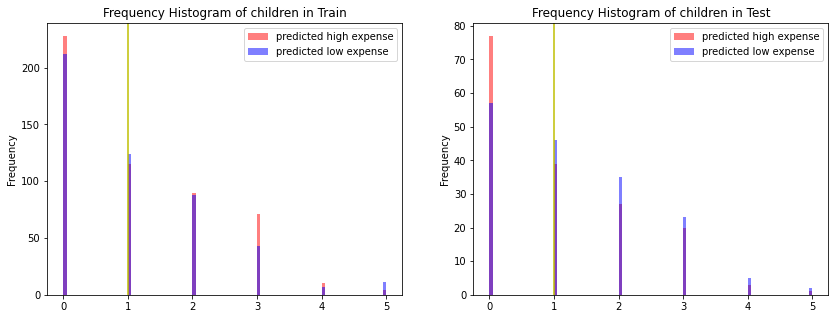

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

x1 = df_train.loc[df_train.predicted_exp_bin==1, 'children']
x2 = df_train.loc[df_train.predicted_exp_bin==0, 'children']
kwargs = dict(alpha=0.5, bins=100)
ax[0].hist(x1, **kwargs, color='r', label='predicted high expense')
ax[0].hist(x2, **kwargs, color='b', label='predicted low expense')
ax[0].set(title='Frequency Histogram of children in Train', ylabel='Frequency')
ax[0].axvline(x=1,color='y')
ax[0].legend()

x1 = df_test.loc[df_test.predicted_exp_bin==1, 'children']
x2 = df_test.loc[df_test.predicted_exp_bin==0, 'children']
kwargs = dict(alpha=0.5, bins=100)
ax[1].hist(x1, **kwargs, color='r', label='predicted high expense')
ax[1].hist(x2, **kwargs, color='b', label='predicted low expense')
ax[1].set(title='Frequency Histogram of children in Test', ylabel='Frequency')
ax[1].axvline(x=1,color='y')
ax[1].legend()

seems like people with less children get charged more.

In [39]:
# split into priv and unpriv for train and test
df_train_priv = df_train[df_train['children']>1].copy()
df_train_unpriv = df_train[df_train['children']<=1].copy()

df_test_priv = df_test[df_test['children']>1].copy()
df_test_unpriv = df_test[df_test['children']<=1].copy()

print(df_train_priv.shape, df_train_unpriv.shape)
print(df_test_priv.shape, df_test_unpriv.shape)

(324, 10) (679, 10)
(116, 10) (219, 10)


In [40]:
# Regression accuracy

# train
train_priv_r2 = r2_score(df_train_priv['expenses'], 
                         df_train_priv['predicted_expenses'])
train_reg_acc_priv.append(train_priv_r2)
print("Training Regression Accuracy for privileged group: ", train_priv_r2)

train_unpriv_r2 = r2_score(df_train_unpriv['expenses'], 
                           df_train_unpriv['predicted_expenses'])
train_reg_acc_unpriv.append(train_unpriv_r2)
print("Training Regression Accuracy for unprivileged group: ", train_unpriv_r2)

# test
test_priv_r2 = r2_score(df_test_priv['expenses'], 
                        df_test_priv['predicted_expenses'])
test_reg_acc_priv.append(test_priv_r2)
print("Testing Regression Accuracy for privileged group: ", test_priv_r2)

test_unpriv_r2 = r2_score(df_test_unpriv['expenses'], 
                          df_test_unpriv['predicted_expenses'])
test_reg_acc_unpriv.append(test_unpriv_r2)
print("Tesing Regression Accuracy for unprivileged group: ", test_unpriv_r2)

Training Regression Accuracy for privileged group:  0.8702350702749333
Training Regression Accuracy for unprivileged group:  0.8799012900739319
Testing Regression Accuracy for privileged group:  0.8774653081461551
Tesing Regression Accuracy for unprivileged group:  0.9062575631226408


In [41]:
# Binary accuracy

# train
train_priv_acc = accuracy_score(df_train_priv['exp_bin'], 
                                df_train_priv['predicted_exp_bin'])
train_bin_acc_priv.append(train_priv_acc)
print("Training Binary Accuracy for privileged group: ", train_priv_acc)

train_unpriv_acc = accuracy_score(df_train_unpriv['exp_bin'], 
                                df_train_unpriv['predicted_exp_bin'])
train_bin_acc_unpriv.append(train_unpriv_acc)
print("Training Binary Accuracy for unprivileged group: ", train_unpriv_acc)

# test
test_priv_acc = accuracy_score(df_test_priv['exp_bin'], 
                               df_test_priv['predicted_exp_bin'])
test_bin_acc_priv.append(test_priv_acc)
print("Testing Binary Accuracy for privileged group: ", test_priv_acc)

test_unpriv_acc = accuracy_score(df_test_unpriv['exp_bin'], 
                                 df_test_unpriv['predicted_exp_bin'])
test_bin_acc_unpriv.append(test_unpriv_acc)
print("Testing Binary Accuracy for unprivileged group: ", test_unpriv_acc)

Training Binary Accuracy for privileged group:  0.8981481481481481
Training Binary Accuracy for unprivileged group:  0.8630338733431517
Testing Binary Accuracy for privileged group:  0.8620689655172413
Testing Binary Accuracy for unprivileged group:  0.8767123287671232


## sex

In [42]:
df['sex'].nunique()

2

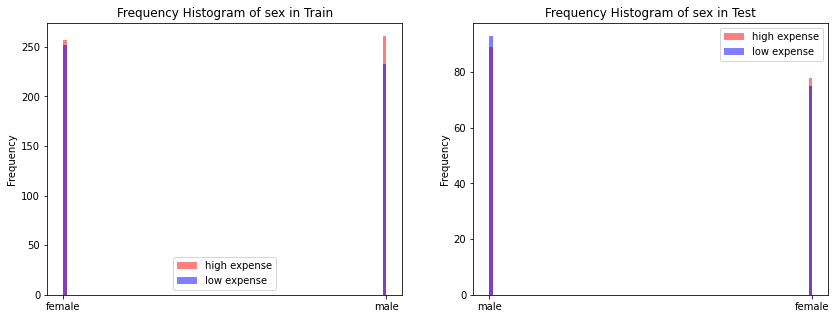

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

x1 = df_train.loc[df_train.predicted_exp_bin==1, 'sex']
x2 = df_train.loc[df_train.predicted_exp_bin==0, 'sex']
kwargs = dict(alpha=0.5, bins=100)
ax[0].hist(x1, **kwargs, color='r', label='high expense')
ax[0].hist(x2, **kwargs, color='b', label='low expense')
ax[0].set(title='Frequency Histogram of sex in Train', ylabel='Frequency')
ax[0].legend()

x1 = df_test.loc[df_test.predicted_exp_bin==1, 'sex']
x2 = df_test.loc[df_test.predicted_exp_bin==0, 'sex']
kwargs = dict(alpha=0.5, bins=100)
ax[1].hist(x1, **kwargs, color='r', label='high expense')
ax[1].hist(x2, **kwargs, color='b', label='low expense')
ax[1].set(title='Frequency Histogram of sex in Test', ylabel='Frequency')
ax[1].legend()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[Text(0.5, 1.0, 'predicted expenses by sex in test')]

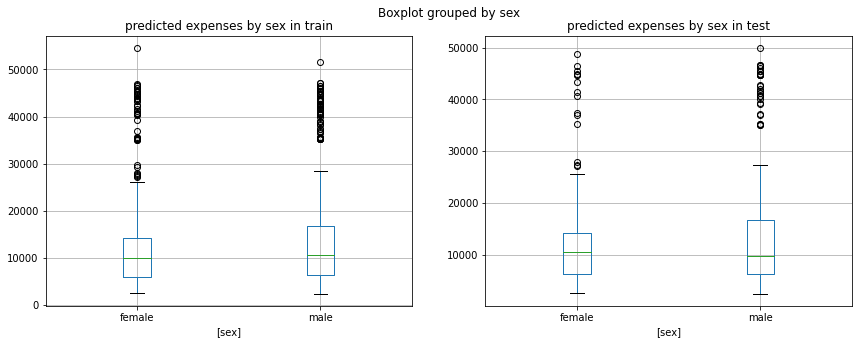

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

df_train.boxplot(column=['predicted_expenses'], by=['sex'], ax=ax[0])
ax[0].set(title='predicted expenses by sex in train')

df_test.boxplot(column=['predicted_expenses'], by=['sex'], ax=ax[1])
ax[1].set(title='predicted expenses by sex in test')

Since males have more higher outliers, we will set that group as unpriviledged.

In [45]:
# split into priv and unpriv for train and test
df_train_priv = df_train[df_train['sex']=='male'].copy()
df_train_unpriv = df_train[df_train['sex']=='female'].copy()

df_test_priv = df_test[df_test['sex']=='male'].copy()
df_test_unpriv = df_test[df_test['sex']=='female'].copy()

print(df_train_priv.shape, df_train_unpriv.shape)
print(df_test_priv.shape, df_test_unpriv.shape)

(494, 10) (509, 10)
(182, 10) (153, 10)


In [46]:
# Regression accuracy

# train
train_priv_r2 = r2_score(df_train_priv['expenses'], 
                         df_train_priv['predicted_expenses'])
train_reg_acc_priv.append(train_priv_r2)
print("Training Regression Accuracy for privileged group: ", train_priv_r2)

train_unpriv_r2 = r2_score(df_train_unpriv['expenses'], 
                           df_train_unpriv['predicted_expenses'])
train_reg_acc_unpriv.append(train_unpriv_r2)
print("Training Regression Accuracy for unprivileged group: ", train_unpriv_r2)

# test
test_priv_r2 = r2_score(df_test_priv['expenses'], 
                        df_test_priv['predicted_expenses'])
test_reg_acc_priv.append(test_priv_r2)
print("Testing Regression Accuracy for privileged group: ", test_priv_r2)

test_unpriv_r2 = r2_score(df_test_unpriv['expenses'], 
                          df_test_unpriv['predicted_expenses'])
test_reg_acc_unpriv.append(test_unpriv_r2)
print("Tesing Regression Accuracy for unprivileged group: ", test_unpriv_r2)

Training Regression Accuracy for privileged group:  0.8888785181483376
Training Regression Accuracy for unprivileged group:  0.8643158186161098
Testing Regression Accuracy for privileged group:  0.9185211351379828
Tesing Regression Accuracy for unprivileged group:  0.8532153196959739


In [47]:
# Binary accuracy

# train
train_priv_acc = accuracy_score(df_train_priv['exp_bin'], 
                                df_train_priv['predicted_exp_bin'])
train_bin_acc_priv.append(train_priv_acc)
print("Training Binary Accuracy for privileged group: ", train_priv_acc)

train_unpriv_acc = accuracy_score(df_train_unpriv['exp_bin'], 
                                df_train_unpriv['predicted_exp_bin'])
train_bin_acc_unpriv.append(train_unpriv_acc)
print("Training Binary Accuracy for unprivileged group: ", train_unpriv_acc)

# test
test_priv_acc = accuracy_score(df_test_priv['exp_bin'], 
                               df_test_priv['predicted_exp_bin'])
test_bin_acc_priv.append(test_priv_acc)
print("Testing Binary Accuracy for privileged group: ", test_priv_acc)

test_unpriv_acc = accuracy_score(df_test_unpriv['exp_bin'], 
                                 df_test_unpriv['predicted_exp_bin'])
test_bin_acc_unpriv.append(test_unpriv_acc)
print("Testing Binary Accuracy for unprivileged group: ", test_unpriv_acc)

Training Binary Accuracy for privileged group:  0.8744939271255061
Training Binary Accuracy for unprivileged group:  0.8742632612966601
Testing Binary Accuracy for privileged group:  0.8626373626373627
Testing Binary Accuracy for unprivileged group:  0.8823529411764706


## smoker

In [48]:
df['sex'].nunique()

2

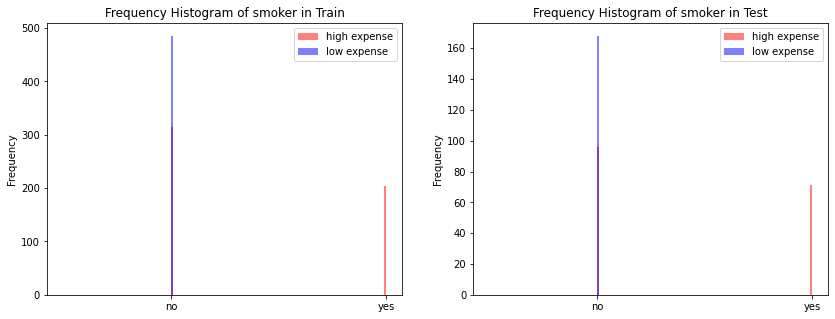

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

x1 = df_train.loc[df_train.predicted_exp_bin==1, 'smoker']
x2 = df_train.loc[df_train.predicted_exp_bin==0, 'smoker']
kwargs = dict(alpha=0.5, bins=100)
ax[0].hist(x1, **kwargs, color='r', label='high expense')
ax[0].hist(x2, **kwargs, color='b', label='low expense')
ax[0].set(title='Frequency Histogram of smoker in Train', ylabel='Frequency')
ax[0].legend()

x1 = df_test.loc[df_test.predicted_exp_bin==1, 'smoker']
x2 = df_test.loc[df_test.predicted_exp_bin==0, 'smoker']
kwargs = dict(alpha=0.5, bins=100)
ax[1].hist(x1, **kwargs, color='r', label='high expense')
ax[1].hist(x2, **kwargs, color='b', label='low expense')
ax[1].set(title='Frequency Histogram of smoker in Test', ylabel='Frequency')
ax[1].legend()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[Text(0.5, 1.0, 'predicted expenses by smoker in test')]

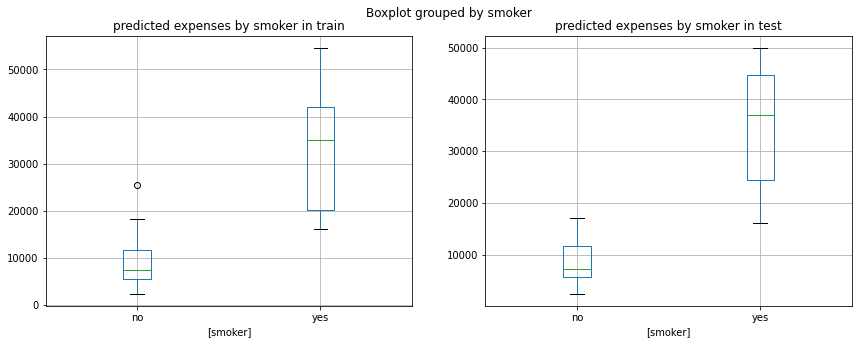

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

df_train.boxplot(column=['predicted_expenses'], by=['smoker'], ax=ax[0])
ax[0].set(title='predicted expenses by smoker in train')

df_test.boxplot(column=['predicted_expenses'], by=['smoker'], ax=ax[1])
ax[1].set(title='predicted expenses by smoker in test')

Since smokers have more higher outliers, we will set that group as unpriviledged.

In [51]:
# split into priv and unpriv for train and test
df_train_priv = df_train[df_train['smoker']=='no'].copy()
df_train_unpriv = df_train[df_train['smoker']=='yes'].copy()

df_test_priv = df_test[df_test['smoker']=='no'].copy()
df_test_unpriv = df_test[df_test['smoker']=='yes'].copy()

print(df_train_priv.shape, df_train_unpriv.shape)
print(df_test_priv.shape, df_test_unpriv.shape)

(800, 10) (203, 10)
(264, 10) (71, 10)


In [52]:
# Regression accuracy

# train
train_priv_r2 = r2_score(df_train_priv['expenses'], 
                         df_train_priv['predicted_expenses'])
train_reg_acc_priv.append(train_priv_r2)
print("Training Regression Accuracy for privileged group: ", train_priv_r2)

train_unpriv_r2 = r2_score(df_train_unpriv['expenses'], 
                           df_train_unpriv['predicted_expenses'])
train_reg_acc_unpriv.append(train_unpriv_r2)
print("Training Regression Accuracy for unprivileged group: ", train_unpriv_r2)

# test
test_priv_r2 = r2_score(df_test_priv['expenses'], 
                        df_test_priv['predicted_expenses'])
test_reg_acc_priv.append(test_priv_r2)
print("Testing Regression Accuracy for privileged group: ", test_priv_r2)

test_unpriv_r2 = r2_score(df_test_unpriv['expenses'], 
                          df_test_unpriv['predicted_expenses'])
test_reg_acc_unpriv.append(test_unpriv_r2)
print("Tesing Regression Accuracy for unprivileged group: ", test_unpriv_r2)

Training Regression Accuracy for privileged group:  0.48189194715175465
Training Regression Accuracy for unprivileged group:  0.9318290313638369
Testing Regression Accuracy for privileged group:  0.45755575663434866
Tesing Regression Accuracy for unprivileged group:  0.8848705324107743


In [53]:
# Binary accuracy

# train
train_priv_acc = accuracy_score(df_train_priv['exp_bin'], 
                                df_train_priv['predicted_exp_bin'])
train_bin_acc_priv.append(train_priv_acc)
print("Training Binary Accuracy for privileged group: ", train_priv_acc)

train_unpriv_acc = accuracy_score(df_train_unpriv['exp_bin'], 
                                df_train_unpriv['predicted_exp_bin'])
train_bin_acc_unpriv.append(train_unpriv_acc)
print("Training Binary Accuracy for unprivileged group: ", train_unpriv_acc)

# test
test_priv_acc = accuracy_score(df_test_priv['exp_bin'], 
                               df_test_priv['predicted_exp_bin'])
test_bin_acc_priv.append(test_priv_acc)
print("Testing Binary Accuracy for privileged group: ", test_priv_acc)

test_unpriv_acc = accuracy_score(df_test_unpriv['exp_bin'], 
                                 df_test_unpriv['predicted_exp_bin'])
test_bin_acc_unpriv.append(test_unpriv_acc)
print("Testing Binary Accuracy for unprivileged group: ", test_unpriv_acc)

Training Binary Accuracy for privileged group:  0.8425
Training Binary Accuracy for unprivileged group:  1.0
Testing Binary Accuracy for privileged group:  0.8371212121212122
Testing Binary Accuracy for unprivileged group:  1.0


## region

Even though `region` was not used to train the model, the model could still present bias towards this features through its correlation with other features.

In [54]:
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[Text(0.5, 1.0, 'predicted expenses by region in test')]

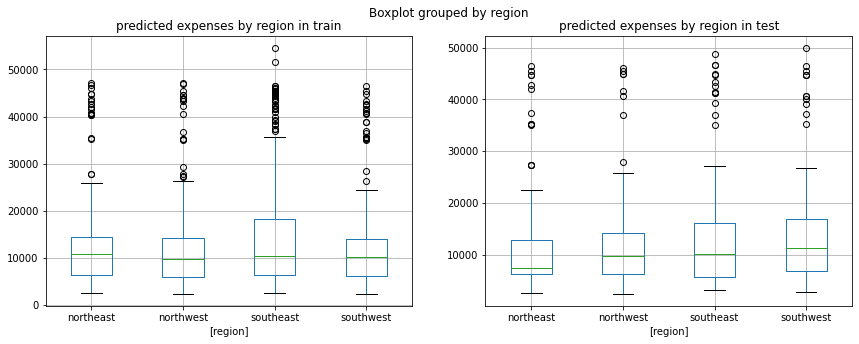

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

df_train.boxplot(column=['predicted_expenses'], by=['region'], ax=ax[0])
ax[0].set(title='predicted expenses by region in train')

df_test.boxplot(column=['predicted_expenses'], by=['region'], ax=ax[1])
ax[1].set(title='predicted expenses by region in test')

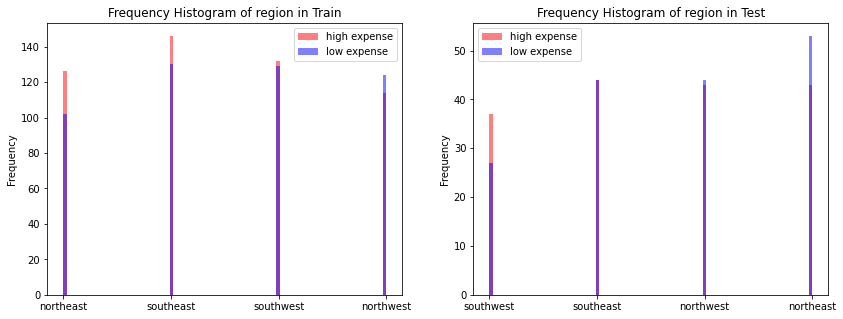

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

x1 = df_train.loc[df_train.predicted_exp_bin==1, 'region']
x2 = df_train.loc[df_train.predicted_exp_bin==0, 'region']
kwargs = dict(alpha=0.5, bins=100)
ax[0].hist(x1, **kwargs, color='r', label='high expense')
ax[0].hist(x2, **kwargs, color='b', label='low expense')
ax[0].set(title='Frequency Histogram of region in Train', ylabel='Frequency')
ax[0].legend()

x1 = df_test.loc[df_test.predicted_exp_bin==1, 'region']
x2 = df_test.loc[df_test.predicted_exp_bin==0, 'region']
kwargs = dict(alpha=0.5, bins=100)
ax[1].hist(x1, **kwargs, color='r', label='high expense')
ax[1].hist(x2, **kwargs, color='b', label='low expense')
ax[1].set(title='Frequency Histogram of region in Test', ylabel='Frequency')
ax[1].legend()

Since southwest regions have more higher expenses, we will set that group as unpriviledged.

In [57]:
# split into priv and unpriv for train and test
df_train_priv = df_train[df_train['region']!='southwest'].copy()
df_train_unpriv = df_train[df_train['region']=='southwest'].copy()

df_test_priv = df_test[df_test['region']!='southwest'].copy()
df_test_unpriv = df_test[df_test['region']=='southwest'].copy()

print(df_train_priv.shape, df_train_unpriv.shape)
print(df_test_priv.shape, df_test_unpriv.shape)

(742, 10) (261, 10)
(271, 10) (64, 10)


In [58]:
# Regression accuracy

# train
train_priv_r2 = r2_score(df_train_priv['expenses'], 
                         df_train_priv['predicted_expenses'])
train_reg_acc_priv.append(train_priv_r2)
print("Training Regression Accuracy for privileged group: ", train_priv_r2)

train_unpriv_r2 = r2_score(df_train_unpriv['expenses'], 
                           df_train_unpriv['predicted_expenses'])
train_reg_acc_unpriv.append(train_unpriv_r2)
print("Training Regression Accuracy for unprivileged group: ", train_unpriv_r2)

# test
test_priv_r2 = r2_score(df_test_priv['expenses'], 
                        df_test_priv['predicted_expenses'])
test_reg_acc_priv.append(test_priv_r2)
print("Testing Regression Accuracy for privileged group: ", test_priv_r2)

test_unpriv_r2 = r2_score(df_test_unpriv['expenses'], 
                          df_test_unpriv['predicted_expenses'])
test_reg_acc_unpriv.append(test_unpriv_r2)
print("Tesing Regression Accuracy for unprivileged group: ", test_unpriv_r2)

Training Regression Accuracy for privileged group:  0.8787242142189552
Training Regression Accuracy for unprivileged group:  0.8730612086177651
Testing Regression Accuracy for privileged group:  0.8897802999384035
Tesing Regression Accuracy for unprivileged group:  0.9171291924841326


In [59]:
# Binary accuracy

# train
train_priv_acc = accuracy_score(df_train_priv['exp_bin'], 
                                df_train_priv['predicted_exp_bin'])
train_bin_acc_priv.append(train_priv_acc)
print("Training Binary Accuracy for privileged group: ", train_priv_acc)

train_unpriv_acc = accuracy_score(df_train_unpriv['exp_bin'], 
                                df_train_unpriv['predicted_exp_bin'])
train_bin_acc_unpriv.append(train_unpriv_acc)
print("Training Binary Accuracy for unprivileged group: ", train_unpriv_acc)

# test
test_priv_acc = accuracy_score(df_test_priv['exp_bin'], 
                               df_test_priv['predicted_exp_bin'])
test_bin_acc_priv.append(test_priv_acc)
print("Testing Binary Accuracy for privileged group: ", test_priv_acc)

test_unpriv_acc = accuracy_score(df_test_unpriv['exp_bin'], 
                                 df_test_unpriv['predicted_exp_bin'])
test_bin_acc_unpriv.append(test_unpriv_acc)
print("Testing Binary Accuracy for unprivileged group: ", test_unpriv_acc)

Training Binary Accuracy for privileged group:  0.8773584905660378
Training Binary Accuracy for unprivileged group:  0.8659003831417624
Testing Binary Accuracy for privileged group:  0.8745387453874539
Testing Binary Accuracy for unprivileged group:  0.859375


# plot accuracy across subgroups

[Text(0, 0.5, 'accuracy'), Text(0.5, 1.0, 'test set')]

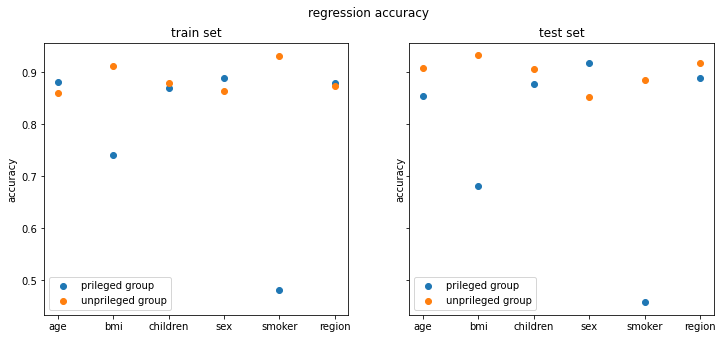

In [60]:
fig, axe = plt.subplots(1, 2, figsize=(12,5), sharey=True)
plt.suptitle("regression accuracy")
x = ['age','bmi','children','sex','smoker','region']

axe[0].scatter(x, train_reg_acc_priv, label='prileged group')
axe[0].scatter(x, train_reg_acc_unpriv, label='unprileged group')
axe[0].legend()
axe[0].set(title='train set', ylabel='accuracy')

axe[1].scatter(x, test_reg_acc_priv, label='prileged group')
axe[1].scatter(x, test_reg_acc_unpriv, label='unprileged group')
axe[1].legend()
axe[1].set(title='test set', ylabel='accuracy')

[Text(0, 0.5, 'accuracy'), Text(0.5, 1.0, 'test set')]

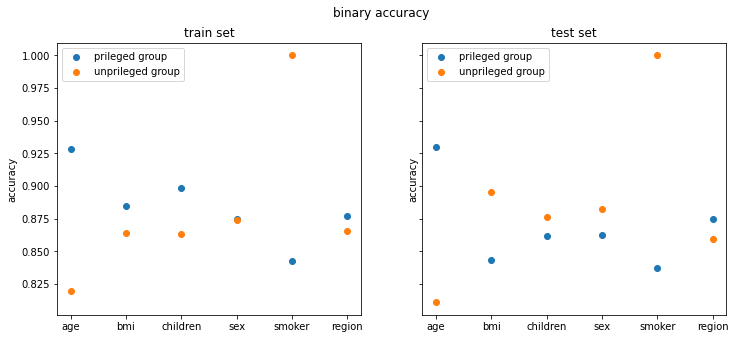

In [61]:
fig, axe = plt.subplots(1, 2, figsize=(12,5), sharey=True)
plt.suptitle("binary accuracy")
x = ['age','bmi','children','sex','smoker','region']

axe[0].scatter(x, train_bin_acc_priv, label='prileged group')
axe[0].scatter(x, train_bin_acc_unpriv, label='unprileged group')
axe[0].legend()
axe[0].set(title='train set', ylabel='accuracy')

axe[1].scatter(x, test_bin_acc_priv, label='prileged group')
axe[1].scatter(x, test_bin_acc_unpriv, label='unprileged group')
axe[1].legend()
axe[1].set(title='test set', ylabel='accuracy')

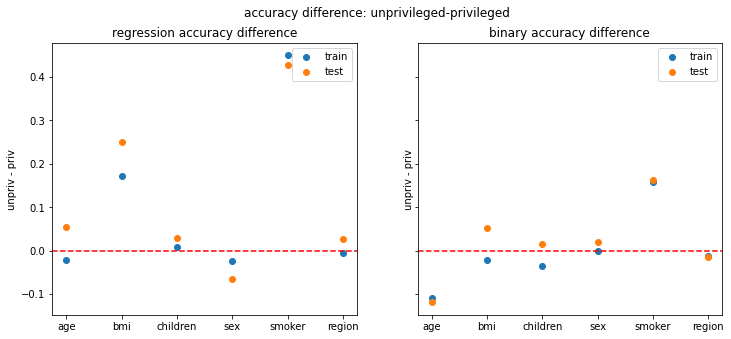

In [62]:
fig, axe = plt.subplots(1, 2, figsize=(12,5), sharey=True)
plt.suptitle("accuracy difference: unprivileged-privileged")
x = ['age','bmi','children','sex','smoker','region']

axe[0].scatter(x, [a_i - b_i for a_i, b_i in zip(train_reg_acc_unpriv, train_reg_acc_priv)], 
            label='train')
axe[0].scatter(x, [a_i - b_i for a_i, b_i in zip(test_reg_acc_unpriv, test_reg_acc_priv)], 
            label='test')
axe[0].legend()
axe[0].set(title='regression accuracy difference', ylabel='unpriv - priv')
axe[0].axhline(y=0, color='r', linestyle='--')

axe[1].scatter(x, [a_i - b_i for a_i, b_i in zip(train_bin_acc_unpriv, train_bin_acc_priv)], 
            label='train')
axe[1].scatter(x, [a_i - b_i for a_i, b_i in zip(test_bin_acc_unpriv, test_bin_acc_priv)], 
            label='test')
axe[1].legend()
axe[1].set(title='binary accuracy difference', ylabel='unpriv - priv')
axe[1].axhline(y=0, color='r', linestyle='--')

A negative value below the dotted line means that the unprivileged group has lower accuracy than the privileged group.

A positive value above the dotted line means that the unprivileged group has higher accuracy than the privileged group.

# Fairness Metrics

## overall

In [63]:
# for train
df_temp = df_train

y_true = df_temp['exp_bin']
y_pred = df_temp['predicted_exp_bin']

cm = confusion_matrix(y_true, y_pred)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
cm_df = pd.DataFrame(data=cm,
                     index=['0: true low exp', '1: true high exp'],
                     columns=['0: predicted low exp', '1: predicted high exp'])
cm_df

,0: predicted low exp,1: predicted high exp
0: true low exp,443,84
1: true high exp,42,434


In [64]:
# just making sure labels were assigned correctly by default
y_temp = y_true.copy()
y_temp = y_temp[y_true==y_pred]
y_temp = y_temp[y_temp==1]
len(y_temp)

434

[Text(0.5, 1.0, 'Confusion Matrix for Test')]

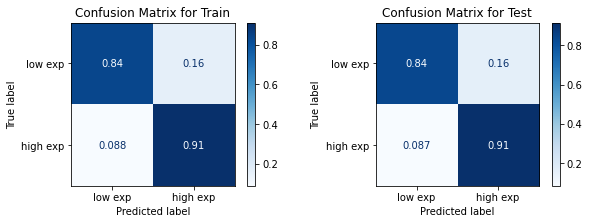

In [65]:
# for train and test
df_temp1 = df_train
df_temp2 = df_test

fig, axe = plt.subplots(1,2,figsize=(10,3))

y_true = df_temp1['exp_bin']
y_pred = df_temp1['predicted_exp_bin']
cm = confusion_matrix(y_true, y_pred)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['low exp', 'high exp'])
disp.plot(cmap='Blues',ax=axe[0])
axe[0].set(title='Confusion Matrix for Train')

y_true = df_temp2['exp_bin']
y_pred = df_temp2['predicted_exp_bin']
cm = confusion_matrix(y_true, y_pred)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['low exp', 'high exp'])
disp.plot(cmap='Blues',ax=axe[1])
axe[1].set(title='Confusion Matrix for Test')

In [66]:
def five_metrics(y_true, y_pred):
  # both inputs are binary classifications
  
  n = len(y_true)
  cm = confusion_matrix(y_true, y_pred, normalize='true', labels=[0,1])

  select_rate = (n - y_pred.sum()) / n
    # percentage of predictions that are good
    # good cases are 0's, not 1's
  acc = accuracy_score(y_true, y_pred)
  FNR = cm[1,0]
    # predicted 0 (low exp) but are actually 1 (high exp)
  FPR = cm[0,1]
    # predicted 1 (high exp) but are actually 0 (low exp)
  
  return [n, select_rate, acc, FNR, FPR]

In [67]:
# for train and test
df_temp1 = df_train
df_temp2 = df_test

# fig, axe = plt.subplots(1,2,figsize=(10,3))

y_true = df_temp1['exp_bin']
y_pred = df_temp1['predicted_exp_bin']
row1 = five_metrics(y_true, y_pred)

y_true = df_temp2['exp_bin']
y_pred = df_temp2['predicted_exp_bin']
row2 = five_metrics(y_true, y_pred)

df_fair = pd.DataFrame(columns=['sample size', 'selection rate', 'accuracy', 'FNR', 'FPR'],
                       index=['train', 'test'])
df_fair.loc['train'] = row1
df_fair.loc['test'] = row2
df_fair

,sample size,selection rate,accuracy,FNR,FPR
train,1003,0.483549,0.874377,0.0882353,0.159393
test,335,0.501493,0.871642,0.0866667,0.162162


In [68]:
# allocate some lists for plotting overall metrics later
# all difference are using (unpriv-priv)
train_acc_dif=[]
test_acc_dif=[]

train_sr_dif=[]
test_sr_dif=[]

train_fnr_dif=[]
test_fnr_dif=[]

train_fpr_dif=[]
test_fpr_dif=[]

## age

In [69]:
# split into priv and unpriv for train and test
df_train_priv = df_train[df_train['age']<=39].copy()
df_train_unpriv = df_train[df_train['age']>39].copy()

df_test_priv = df_test[df_test['age']<=39].copy()
df_test_unpriv = df_test[df_test['age']>39].copy()

print(df_train_priv.shape, df_train_unpriv.shape)
print(df_test_priv.shape, df_test_unpriv.shape)

(503, 10) (500, 10)
(171, 10) (164, 10)


In [70]:
data = []
for d in [df_train_priv, df_train_unpriv, df_test_priv, df_test_unpriv]:
  y_true = d['exp_bin']
  y_pred = d['predicted_exp_bin']
  row = five_metrics(y_true, y_pred)
  data.append(row)

In [71]:
# create multi-index for dataframe 
tuples = [('train', 'privileged'),
          ('train', 'unprivileged'),
          ('test', 'privileged'),
          ('test', 'unprivileged')]

index = pd.MultiIndex.from_tuples(tuples, names=["data", "age"])

df_fair = pd.DataFrame(data,
                       columns=['sample size', 'selection rate', 'accuracy', 'FNR', 'FPR'],
                       index=index)
df_fair

sample size  selection rate  accuracy       FNR       FPR
data  age                                                                    
train privileged            503        0.777336  0.928429  0.243243  0.000000
      unprivileged          500        0.188000  0.820000  0.018293  0.488372
test  privileged            171        0.812865  0.929825  0.272727  0.000000
      unprivileged          164        0.176829  0.810976  0.009434  0.517241

In [72]:
train_acc_dif.append(df_fair.loc[('train','unprivileged'),'accuracy']- df_fair.loc[('train','privileged'),'accuracy'])
test_acc_dif.append(df_fair.loc[('test','unprivileged'),'accuracy']- df_fair.loc[('test','privileged'),'accuracy'])

train_sr_dif.append(df_fair.loc[('train','unprivileged'),'selection rate']- df_fair.loc[('train','privileged'),'selection rate'])
test_sr_dif.append(df_fair.loc[('test','unprivileged'),'selection rate']- df_fair.loc[('test','privileged'),'selection rate'])

train_fnr_dif.append(df_fair.loc[('train','unprivileged'),'FNR']- df_fair.loc[('train','privileged'),'FNR'])
test_fnr_dif.append(df_fair.loc[('test','unprivileged'),'FNR']- df_fair.loc[('test','privileged'),'FNR'])

train_fpr_dif.append(df_fair.loc[('train','unprivileged'),'FPR']- df_fair.loc[('train','privileged'),'FPR'])
test_fpr_dif.append(df_fair.loc[('test','unprivileged'),'FPR']- df_fair.loc[('test','privileged'),'FPR'])

## bmi

In [73]:
# split into priv and unpriv for train and test
df_train_priv = df_train[df_train['bmi']<=30].copy()
df_train_unpriv = df_train[df_train['bmi']>30].copy()

df_test_priv = df_test[df_test['bmi']<=30].copy()
df_test_unpriv = df_test[df_test['bmi']>30].copy()

print(df_train_priv.shape, df_train_unpriv.shape)
print(df_test_priv.shape, df_test_unpriv.shape)

(487, 10) (516, 10)
(153, 10) (182, 10)


In [74]:
data = []
for d in [df_train_priv, df_train_unpriv, df_test_priv, df_test_unpriv]:
  y_true = d['exp_bin']
  y_pred = d['predicted_exp_bin']
  row = five_metrics(y_true, y_pred)
  data.append(row)

In [75]:
# create multi-index for dataframe 
tuples = [('train', 'privileged'),
          ('train', 'unprivileged'),
          ('test', 'privileged'),
          ('test', 'unprivileged')]

index = pd.MultiIndex.from_tuples(tuples, names=["data", "BMI"])

df_fair = pd.DataFrame(data,
                       columns=['sample size', 'selection rate', 'accuracy', 'FNR', 'FPR'],
                       index=index)
df_fair

sample size  selection rate  accuracy       FNR       FPR
data  BMI                                                                    
train privileged            487        0.523614  0.885010  0.084906  0.138182
      unprivileged          516        0.445736  0.864341  0.090909  0.182540
test  privileged            153        0.509804  0.843137  0.107692  0.193182
      unprivileged          182        0.494505  0.895604  0.070588  0.134021

In [76]:
train_acc_dif.append(df_fair.loc[('train','unprivileged'),'accuracy']- df_fair.loc[('train','privileged'),'accuracy'])
test_acc_dif.append(df_fair.loc[('test','unprivileged'),'accuracy']- df_fair.loc[('test','privileged'),'accuracy'])

train_sr_dif.append(df_fair.loc[('train','unprivileged'),'selection rate']- df_fair.loc[('train','privileged'),'selection rate'])
test_sr_dif.append(df_fair.loc[('test','unprivileged'),'selection rate']- df_fair.loc[('test','privileged'),'selection rate'])

train_fnr_dif.append(df_fair.loc[('train','unprivileged'),'FNR']- df_fair.loc[('train','privileged'),'FNR'])
test_fnr_dif.append(df_fair.loc[('test','unprivileged'),'FNR']- df_fair.loc[('test','privileged'),'FNR'])

train_fpr_dif.append(df_fair.loc[('train','unprivileged'),'FPR']- df_fair.loc[('train','privileged'),'FPR'])
test_fpr_dif.append(df_fair.loc[('test','unprivileged'),'FPR']- df_fair.loc[('test','privileged'),'FPR'])

## children

In [77]:
# split into priv and unpriv for train and test
df_train_priv = df_train[df_train['children']>1].copy()
df_train_unpriv = df_train[df_train['children']<=1].copy()

df_test_priv = df_test[df_test['children']>1].copy()
df_test_unpriv = df_test[df_test['children']<=1].copy()

print(df_train_priv.shape, df_train_unpriv.shape)
print(df_test_priv.shape, df_test_unpriv.shape)

(324, 10) (679, 10)
(116, 10) (219, 10)


In [78]:
data = []
for d in [df_train_priv, df_train_unpriv, df_test_priv, df_test_unpriv]:
  y_true = d['exp_bin']
  y_pred = d['predicted_exp_bin']
  row = five_metrics(y_true, y_pred)
  data.append(row)

In [79]:
# create multi-index for dataframe 
tuples = [('train', 'privileged'),
          ('train', 'unprivileged'),
          ('test', 'privileged'),
          ('test', 'unprivileged')]

index = pd.MultiIndex.from_tuples(tuples, names=["data", "children"])

df_fair = pd.DataFrame(data,
                       columns=['sample size', 'selection rate', 'accuracy', 'FNR', 'FPR'],
                       index=index)
df_fair

sample size  selection rate  accuracy       FNR       FPR
data  children                                                               
train privileged            324        0.459877  0.898148  0.082353  0.123377
      unprivileged          679        0.494845  0.863034  0.091503  0.174263
test  privileged            116        0.560345  0.862069  0.156863  0.123077
      unprivileged          219        0.470320  0.876712  0.050505  0.183333

In [80]:
train_acc_dif.append(df_fair.loc[('train','unprivileged'),'accuracy']- df_fair.loc[('train','privileged'),'accuracy'])
test_acc_dif.append(df_fair.loc[('test','unprivileged'),'accuracy']- df_fair.loc[('test','privileged'),'accuracy'])

train_sr_dif.append(df_fair.loc[('train','unprivileged'),'selection rate']- df_fair.loc[('train','privileged'),'selection rate'])
test_sr_dif.append(df_fair.loc[('test','unprivileged'),'selection rate']- df_fair.loc[('test','privileged'),'selection rate'])

train_fnr_dif.append(df_fair.loc[('train','unprivileged'),'FNR']- df_fair.loc[('train','privileged'),'FNR'])
test_fnr_dif.append(df_fair.loc[('test','unprivileged'),'FNR']- df_fair.loc[('test','privileged'),'FNR'])

train_fpr_dif.append(df_fair.loc[('train','unprivileged'),'FPR']- df_fair.loc[('train','privileged'),'FPR'])
test_fpr_dif.append(df_fair.loc[('test','unprivileged'),'FPR']- df_fair.loc[('test','privileged'),'FPR'])

## sex

In [81]:
# split into priv and unpriv for train and test
df_train_priv = df_train[df_train['sex']=='male'].copy()
df_train_unpriv = df_train[df_train['sex']=='female'].copy()

df_test_priv = df_test[df_test['sex']=='male'].copy()
df_test_unpriv = df_test[df_test['sex']=='female'].copy()

print(df_train_priv.shape, df_train_unpriv.shape)
print(df_test_priv.shape, df_test_unpriv.shape)

(494, 10) (509, 10)
(182, 10) (153, 10)


In [82]:
data = []
for d in [df_train_priv, df_train_unpriv, df_test_priv, df_test_unpriv]:
  y_true = d['exp_bin']
  y_pred = d['predicted_exp_bin']
  row = five_metrics(y_true, y_pred)
  data.append(row)

In [83]:
# create multi-index for dataframe 
tuples = [('train', 'privileged'),
          ('train', 'unprivileged'),
          ('test', 'privileged'),
          ('test', 'unprivileged')]

index = pd.MultiIndex.from_tuples(tuples, names=["data", "sex"])

df_fair = pd.DataFrame(data,
                       columns=['sample size', 'selection rate', 'accuracy', 'FNR', 'FPR'],
                       index=index)
df_fair

sample size  selection rate  accuracy       FNR       FPR
data  sex                                                                    
train privileged            494        0.471660  0.874494  0.093878  0.156627
      unprivileged          509        0.495088  0.874263  0.082251  0.161871
test  privileged            182        0.510989  0.862637  0.067568  0.185185
      unprivileged          153        0.490196  0.882353  0.105263  0.129870

In [84]:
train_acc_dif.append(df_fair.loc[('train','unprivileged'),'accuracy']- df_fair.loc[('train','privileged'),'accuracy'])
test_acc_dif.append(df_fair.loc[('test','unprivileged'),'accuracy']- df_fair.loc[('test','privileged'),'accuracy'])

train_sr_dif.append(df_fair.loc[('train','unprivileged'),'selection rate']- df_fair.loc[('train','privileged'),'selection rate'])
test_sr_dif.append(df_fair.loc[('test','unprivileged'),'selection rate']- df_fair.loc[('test','privileged'),'selection rate'])

train_fnr_dif.append(df_fair.loc[('train','unprivileged'),'FNR']- df_fair.loc[('train','privileged'),'FNR'])
test_fnr_dif.append(df_fair.loc[('test','unprivileged'),'FNR']- df_fair.loc[('test','privileged'),'FNR'])

train_fpr_dif.append(df_fair.loc[('train','unprivileged'),'FPR']- df_fair.loc[('train','privileged'),'FPR'])
test_fpr_dif.append(df_fair.loc[('test','unprivileged'),'FPR']- df_fair.loc[('test','privileged'),'FPR'])

## smoker

In [85]:
# split into priv and unpriv for train and test
df_train_priv = df_train[df_train['smoker']=='no'].copy()
df_train_unpriv = df_train[df_train['smoker']=='yes'].copy()

df_test_priv = df_test[df_test['smoker']=='no'].copy()
df_test_unpriv = df_test[df_test['smoker']=='yes'].copy()

print(df_train_priv.shape, df_train_unpriv.shape)
print(df_test_priv.shape, df_test_unpriv.shape)

(800, 10) (203, 10)
(264, 10) (71, 10)


In [86]:
data = []
for d in [df_train_priv, df_train_unpriv, df_test_priv, df_test_unpriv]:
  y_true = d['exp_bin']
  y_pred = d['predicted_exp_bin']
  row = five_metrics(y_true, y_pred)
  data.append(row)

In [87]:
# create multi-index for dataframe 
tuples = [('train', 'privileged'),
          ('train', 'unprivileged'),
          ('test', 'privileged'),
          ('test', 'unprivileged')]

index = pd.MultiIndex.from_tuples(tuples, names=["data", "smoker"])

df_fair = pd.DataFrame(data,
                       columns=['sample size', 'selection rate', 'accuracy', 'FNR', 'FPR'],
                       index=index)
df_fair

sample size  selection rate  accuracy       FNR       FPR
data  smoker                                                                 
train privileged            800        0.606250  0.842500  0.153846  0.159393
      unprivileged          203        0.000000  1.000000  0.000000  0.000000
test  privileged            264        0.636364  0.837121  0.164557  0.162162
      unprivileged           71        0.000000  1.000000  0.000000  0.000000

In [88]:
train_acc_dif.append(df_fair.loc[('train','unprivileged'),'accuracy']- df_fair.loc[('train','privileged'),'accuracy'])
test_acc_dif.append(df_fair.loc[('test','unprivileged'),'accuracy']- df_fair.loc[('test','privileged'),'accuracy'])

train_sr_dif.append(df_fair.loc[('train','unprivileged'),'selection rate']- df_fair.loc[('train','privileged'),'selection rate'])
test_sr_dif.append(df_fair.loc[('test','unprivileged'),'selection rate']- df_fair.loc[('test','privileged'),'selection rate'])

train_fnr_dif.append(df_fair.loc[('train','unprivileged'),'FNR']- df_fair.loc[('train','privileged'),'FNR'])
test_fnr_dif.append(df_fair.loc[('test','unprivileged'),'FNR']- df_fair.loc[('test','privileged'),'FNR'])

train_fpr_dif.append(df_fair.loc[('train','unprivileged'),'FPR']- df_fair.loc[('train','privileged'),'FPR'])
test_fpr_dif.append(df_fair.loc[('test','unprivileged'),'FPR']- df_fair.loc[('test','privileged'),'FPR'])

## region

Even though `region` was not used to train the model, the model could still present bias towards this features through its correlation with other features.

In [89]:
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [90]:
# split into priv and unpriv for train and test
df_train_priv = df_train[df_train['region']!='southwest'].copy()
df_train_unpriv = df_train[df_train['region']=='southwest'].copy()

df_test_priv = df_test[df_test['region']!='southwest'].copy()
df_test_unpriv = df_test[df_test['region']=='southwest'].copy()

print(df_train_priv.shape, df_train_unpriv.shape)
print(df_test_priv.shape, df_test_unpriv.shape)

(742, 10) (261, 10)
(271, 10) (64, 10)


In [91]:
data = []
for d in [df_train_priv, df_train_unpriv, df_test_priv, df_test_unpriv]:
  y_true = d['exp_bin']
  y_pred = d['predicted_exp_bin']
  row = five_metrics(y_true, y_pred)
  data.append(row)

In [92]:
# create multi-index for dataframe 
tuples = [('train', 'privileged'),
          ('train', 'unprivileged'),
          ('test', 'privileged'),
          ('test', 'unprivileged')]

index = pd.MultiIndex.from_tuples(tuples, names=["data", "region"])

df_fair = pd.DataFrame(data,
                       columns=['sample size', 'selection rate', 'accuracy', 'FNR', 'FPR'],
                       index=index)
df_fair

sample size  selection rate  accuracy       FNR       FPR
data  region                                                                 
train privileged            742        0.479784  0.877358  0.093664  0.150396
      unprivileged          261        0.494253  0.865900  0.070796  0.182432
test  privileged            271        0.520295  0.874539  0.100000  0.145695
      unprivileged           64        0.421875  0.859375  0.033333  0.235294

In [93]:
train_acc_dif.append(df_fair.loc[('train','unprivileged'),'accuracy']- df_fair.loc[('train','privileged'),'accuracy'])
test_acc_dif.append(df_fair.loc[('test','unprivileged'),'accuracy']- df_fair.loc[('test','privileged'),'accuracy'])

train_sr_dif.append(df_fair.loc[('train','unprivileged'),'selection rate']- df_fair.loc[('train','privileged'),'selection rate'])
test_sr_dif.append(df_fair.loc[('test','unprivileged'),'selection rate']- df_fair.loc[('test','privileged'),'selection rate'])

train_fnr_dif.append(df_fair.loc[('train','unprivileged'),'FNR']- df_fair.loc[('train','privileged'),'FNR'])
test_fnr_dif.append(df_fair.loc[('test','unprivileged'),'FNR']- df_fair.loc[('test','privileged'),'FNR'])

train_fpr_dif.append(df_fair.loc[('train','unprivileged'),'FPR']- df_fair.loc[('train','privileged'),'FPR'])
test_fpr_dif.append(df_fair.loc[('test','unprivileged'),'FPR']- df_fair.loc[('test','privileged'),'FPR'])

# plot fairness across subgroups

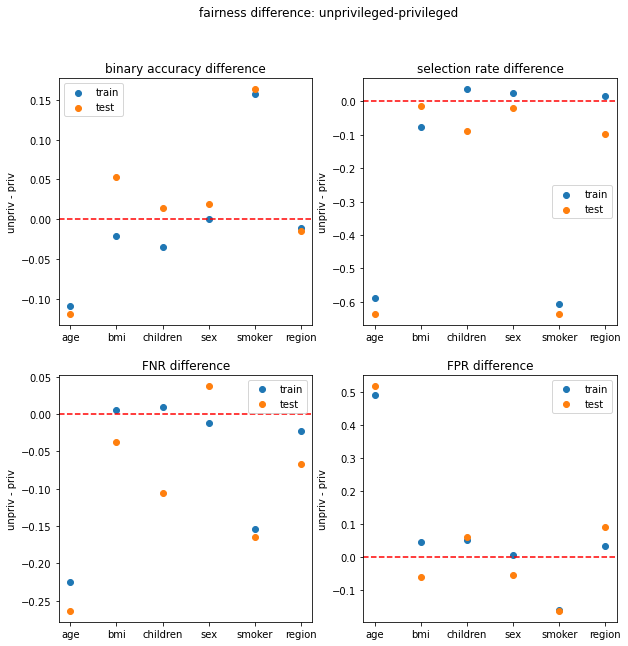

In [94]:
fig, axe = plt.subplots(2,2,figsize=(10,10))

plt.suptitle("fairness difference: unprivileged-privileged")
x = ['age','bmi','children','sex','smoker','region']

axe[0,0].scatter(x, train_acc_dif, label='train')
axe[0,0].scatter(x, test_acc_dif, label='test')
axe[0,0].legend()
axe[0,0].set(title='binary accuracy difference', ylabel="unpriv - priv")
axe[0,0].axhline(y=0, color='r', linestyle='--')

axe[0,1].scatter(x, train_sr_dif, label='train')
axe[0,1].scatter(x, test_sr_dif, label='test')
axe[0,1].legend()
axe[0,1].set(title='selection rate difference', ylabel="unpriv - priv")
axe[0,1].axhline(y=0, color='r', linestyle='--')

axe[1,0].scatter(x, train_fnr_dif, label='train')
axe[1,0].scatter(x, test_fnr_dif, label='test')
axe[1,0].legend()
axe[1,0].set(title='FNR difference', ylabel="unpriv - priv")
axe[1,0].axhline(y=0, color='r', linestyle='--')

axe[1,1].scatter(x, train_fpr_dif, label='train')
axe[1,1].scatter(x, test_fpr_dif, label='test')
axe[1,1].legend()
axe[1,1].set(title='FPR difference', ylabel="unpriv - priv")
axe[1,1].axhline(y=0, color='r', linestyle='--')


# Stability

Given our test set `X_test`, if we add some additional noise to it, will the ADS still give similar predicted values/labels?

we don't add noise to the train set because if we re-train the model it would be another ADS, not the same ADS we are trying to analyze.

## age

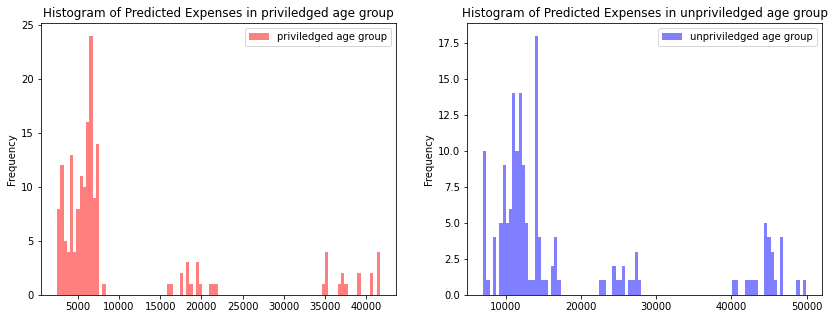

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

x1 = df_test.loc[df_test['age']<=39, 'predicted_expenses']
x2 = df_test.loc[df_test['age']>39, 'predicted_expenses']
kwargs = dict(alpha=0.5, bins=100)

ax[0].hist(x1, **kwargs, color='r', label='priviledged age group')
ax[0].set(title='Histogram of Predicted Expenses in priviledged age group', ylabel='Frequency')
ax[0].legend()

ax[1].hist(x2, **kwargs, color='b', label='unpriviledged age group')
ax[1].set(title='Histogram of Predicted Expenses in unpriviledged age group', ylabel='Frequency')
ax[1].legend()

## bmi

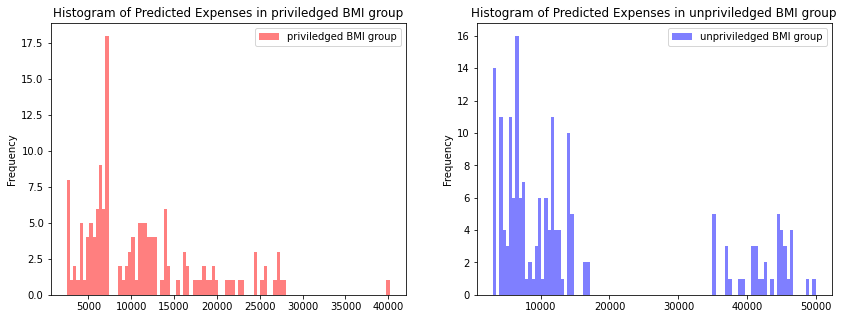

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

x1 = df_test.loc[df_test['bmi']<=30, 'predicted_expenses']
x2 = df_test.loc[df_test['bmi']>30, 'predicted_expenses']
kwargs = dict(alpha=0.5, bins=100)

ax[0].hist(x1, **kwargs, color='r', label='priviledged BMI group')
ax[0].set(title='Histogram of Predicted Expenses in priviledged BMI group', ylabel='Frequency')
ax[0].legend()

ax[1].hist(x2, **kwargs, color='b', label='unpriviledged BMI group')
ax[1].set(title='Histogram of Predicted Expenses in unpriviledged BMI group', ylabel='Frequency')
ax[1].legend()

## children

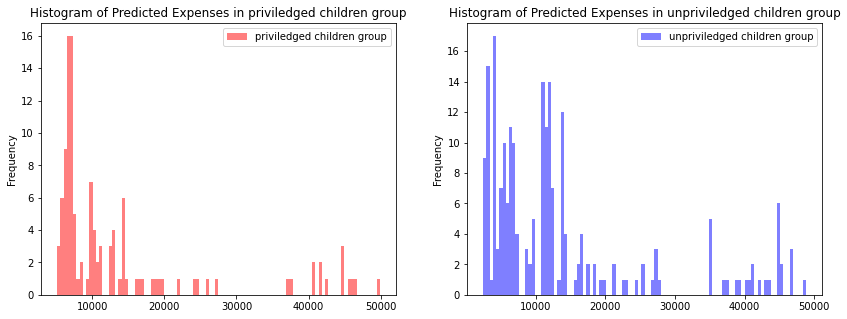

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

x1 = df_test.loc[df_test['children']>1, 'predicted_expenses']
x2 = df_test.loc[df_test['children']<=1, 'predicted_expenses']
kwargs = dict(alpha=0.5, bins=100)

ax[0].hist(x1, **kwargs, color='r', label='priviledged children group')
ax[0].set(title='Histogram of Predicted Expenses in priviledged children group', ylabel='Frequency')
ax[0].legend()

ax[1].hist(x2, **kwargs, color='b', label='unpriviledged children group')
ax[1].set(title='Histogram of Predicted Expenses in unpriviledged children group', ylabel='Frequency')
ax[1].legend()

## sex

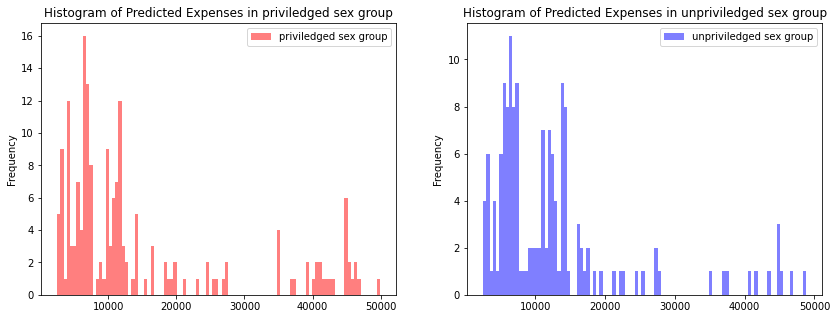

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

x1 = df_test.loc[df_test['sex']=='male', 'predicted_expenses']
x2 = df_test.loc[df_test['sex']=='female', 'predicted_expenses']
kwargs = dict(alpha=0.5, bins=100)

ax[0].hist(x1, **kwargs, color='r', label='priviledged sex group')
ax[0].set(title='Histogram of Predicted Expenses in priviledged sex group', ylabel='Frequency')
ax[0].legend()

ax[1].hist(x2, **kwargs, color='b', label='unpriviledged sex group')
ax[1].set(title='Histogram of Predicted Expenses in unpriviledged sex group', ylabel='Frequency')
ax[1].legend()

## smoker

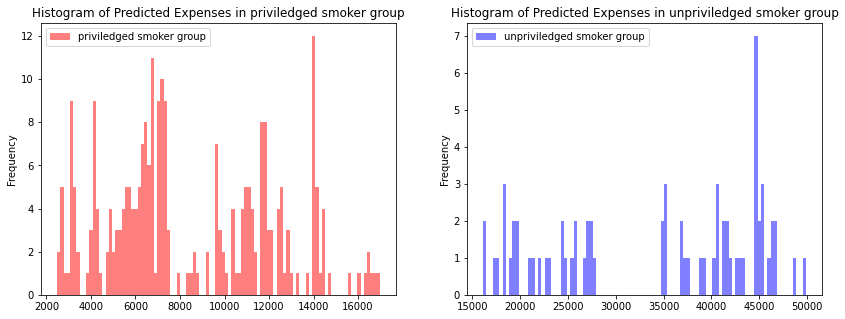

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

x1 = df_test.loc[df_test['smoker']=='no', 'predicted_expenses']
x2 = df_test.loc[df_test['smoker']=='yes', 'predicted_expenses']
kwargs = dict(alpha=0.5, bins=100)

ax[0].hist(x1, **kwargs, color='r', label='priviledged smoker group')
ax[0].set(title='Histogram of Predicted Expenses in priviledged smoker group', ylabel='Frequency')
ax[0].legend()

ax[1].hist(x2, **kwargs, color='b', label='unpriviledged smoker group')
ax[1].set(title='Histogram of Predicted Expenses in unpriviledged smoker group', ylabel='Frequency')
ax[1].legend()

## region

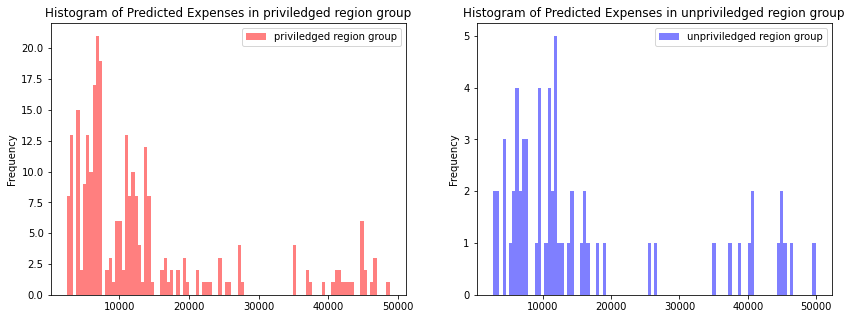

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

x1 = df_test.loc[df_test['region']!='southwest', 'predicted_expenses']
x2 = df_test.loc[df_test['region']=='southwest', 'predicted_expenses']
kwargs = dict(alpha=0.5, bins=100)

ax[0].hist(x1, **kwargs, color='r', label='priviledged region group')
ax[0].set(title='Histogram of Predicted Expenses in priviledged region group', ylabel='Frequency')
ax[0].legend()

ax[1].hist(x2, **kwargs, color='b', label='unpriviledged region group')
ax[1].set(title='Histogram of Predicted Expenses in unpriviledged region group', ylabel='Frequency')
ax[1].legend()

# noise

## add noise to age

In [101]:
X_test_og

,age,sex,bmi,children,smoker
578,52,0,30.2,1,0
610,47,1,29.4,1,0
569,48,0,40.6,2,1
1034,61,0,38.4,0,0
198,51,1,18.1,0,0
...,...,...,...,...,...
574,57,1,34.3,2,0
1174,29,0,32.1,2,0
1327,51,0,30.0,1,0
817,23,0,37.1,3,0


In [102]:
X_test_og['age'].describe()

count    335.000000
mean      39.122388
std       14.040146
min       18.000000
25%       27.000000
50%       39.000000
75%       51.000000
max       64.000000
Name: age, dtype: float64

In [103]:
# add random noise to age
mean = 0
std = 3
n=len(X_test_og)
y_pred = random_forest_reg.predict(X_test)
std_lst = [i for i in range(0,20,2)]
  # higher std more noisy

r2_lst=[]
acc_lst=[]

for std in std_lst:
  # print(f"std: {std}", 100*'=')
  X_test_noisy = X_test_og.copy()
  X_test_noisy['age'] = X_test_noisy['age'] + np.random.normal(0, std, size=n)

  # standardize with fitted scaler
  X_test_noisy = sc.transform(X_test_noisy)

  # predict using noisy scaled data
  y_pred_noisy = random_forest_reg.predict(X_test_noisy)

  r2 = r2_score(y_pred, y_pred_noisy)
  r2_lst.append(r2)
  acc =  accuracy_score(np.where(y_pred>10000,1,0), np.where(y_pred_noisy>10000,1,0))
  acc_lst.append(acc)

  # print("regression similarity between original and noise-added test data:", r2)
  # print("binary similarity between original and noise-added test data:",acc)

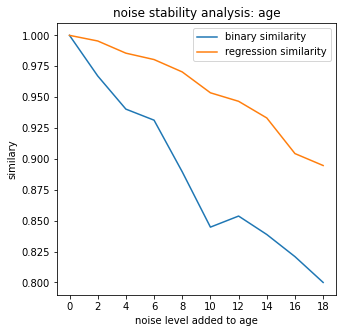

In [104]:
plt.figure(figsize=(5,5))
plt.plot(std_lst, acc_lst, label='binary similarity')
plt.plot(std_lst, r2_lst, label='regression similarity')
plt.xticks(std_lst)
plt.xlabel('noise level added to age')
plt.ylabel('similary')
plt.title('noise stability analysis: age')
plt.legend()

## add noise to bmi

In [119]:
X_test_og['bmi'].describe()

count    335.000000
mean      30.496716
std        5.679416
min       17.200000
25%       26.250000
50%       30.600000
75%       34.300000
max       46.500000
Name: bmi, dtype: float64

In [120]:
# add random noise to bmi
mean = 0
std = 3
n=len(X_test_og)
y_pred = random_forest_reg.predict(X_test)
std_lst = range(0,20,2)
  # higher std more noisy

r2_lst=[]
acc_lst=[]

for std in std_lst:
  # print(f"std: {std}", 100*'=')
  X_test_noisy = X_test_og.copy()
  X_test_noisy['bmi'] = X_test_noisy['bmi'] + np.random.normal(0, std, size=n)

  # standardize with fitted scaler
  X_test_noisy = sc.transform(X_test_noisy)

  # predict using noisy scaled data
  y_pred_noisy = random_forest_reg.predict(X_test_noisy)

  r2 = r2_score(y_pred, y_pred_noisy)
  r2_lst.append(r2)
  acc =  accuracy_score(np.where(y_pred>10000,1,0), np.where(y_pred_noisy>10000,1,0))
  acc_lst.append(acc)

  # print("regression similarity between original and noise-added test data:", r2)
  # print("binary similarity between original and noise-added test data:",acc)

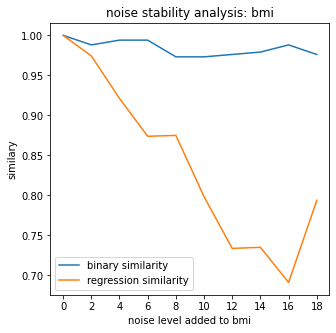

In [121]:
plt.figure(figsize=(5,5))
plt.plot(std_lst, acc_lst, label='binary similarity')
plt.plot(std_lst, r2_lst, label='regression similarity')
plt.xticks(std_lst)
plt.xlabel('noise level added to bmi')
plt.ylabel('similary')
plt.title('noise stability analysis: bmi')
plt.legend()

## add noise to children

In [122]:
X_test_og['children'].describe()

count    335.000000
mean       1.149254
std        1.199473
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: children, dtype: float64

In [123]:
# add random noise to children
mean = 0
std = 3
n=len(X_test_og)
y_pred = random_forest_reg.predict(X_test)
std_lst = range(0,20,2)
  # higher std more noisy

r2_lst2=[]
acc_lst2=[]

for std in std_lst:
  # print(f"std: {std}", 100*'=')
  X_test_noisy = X_test_og.copy()
  X_test_noisy['children'] = X_test_noisy['children'] + np.random.normal(0, std, size=n)

  # standardize with fitted scaler
  X_test_noisy = sc.transform(X_test_noisy)

  # predict using noisy scaled data
  y_pred_noisy = random_forest_reg.predict(X_test_noisy)

  r2 = r2_score(y_pred, y_pred_noisy)
  r2_lst2.append(r2)
  acc =  accuracy_score(np.where(y_pred>10000,1,0), np.where(y_pred_noisy>10000,1,0))
  acc_lst2.append(acc)

  # print("regression similarity between original and noise-added test data:", r2)
  # print("binary similarity between original and noise-added test data:",acc)

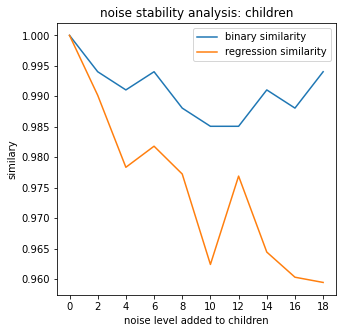

In [124]:
plt.figure(figsize=(5,5))
plt.plot(std_lst, acc_lst2, label='binary similarity')
plt.plot(std_lst, r2_lst2, label='regression similarity')
plt.xticks(std_lst)
plt.xlabel('noise level added to children')
plt.ylabel('similary')
plt.title('noise stability analysis: children')
plt.legend()

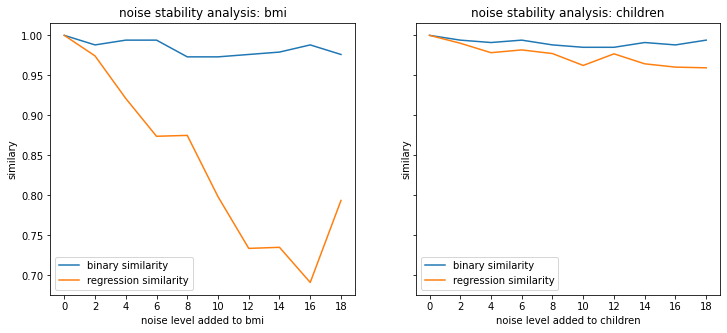

In [125]:
# plot them together
fig,ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)

ax[0].plot(std_lst, acc_lst, label='binary similarity')
ax[0].plot(std_lst, r2_lst, label='regression similarity')
ax[0].set(xticks=std_lst, 
          xlabel = 'noise level added to bmi',
          ylabel='similary',
          title = 'noise stability analysis: bmi'
          )
ax[0].legend()


ax[1].plot(std_lst, acc_lst2, label='binary similarity')
ax[1].plot(std_lst, r2_lst2, label='regression similarity')
ax[1].set(xticks=std_lst, 
          xlabel = 'noise level added to children',
          ylabel='similary',
          title = 'noise stability analysis: children'
          )
ax[1].legend()

# AIF360 Metric

## Protected = Age on train dataset

In [ ]:
dataset_orig_train = StandardDataset(df_train_encoded, protected_attribute_names=['age'],
                             privileged_classes=[lambda x: x <= 39],
                             label_name='predicted_exp_bin',
                             favorable_classes=[0]
                             )


privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]


print("Original one hot encoded dataset shape: ",dataset_orig_train.features.shape)
print("Train dataset shape: ", dataset_orig_train.features.shape)

Original one hot encoded dataset shape:  (1003, 9)
Train dataset shape:  (1003, 9)


In [ ]:
df, dict_df = dataset_orig_train.convert_to_dataframe()

In [ ]:
print("Shape: ", df.shape)
print(df.columns)
df.head(5)

Shape:  (1003, 10)
Index(['predicted_expenses', 'age', 'sex', 'bmi', 'children', 'smoker',
       'region', 'expenses', 'exp_bin', 'predicted_exp_bin'],
      dtype='object')


,predicted_expenses,age,sex,bmi,children,smoker,region,expenses,exp_bin,predicted_exp_bin
1075,5933.590924,1.0,1.0,29.6,1.0,0.0,1.0,4562.84,0.0,0.0
131,14330.325440,0.0,1.0,22.0,0.0,0.0,3.0,13616.36,1.0,1.0
15,3412.916770,1.0,0.0,24.6,1.0,0.0,0.0,1837.24,0.0,0.0
1223,18239.599659,1.0,1.0,24.4,0.0,1.0,1.0,26125.67,1.0,1.0
1137,4366.878864,1.0,1.0,22.2,0.0,0.0,2.0,3176.29,0.0,0.0


Text(0, 0.5, 'Frequency')

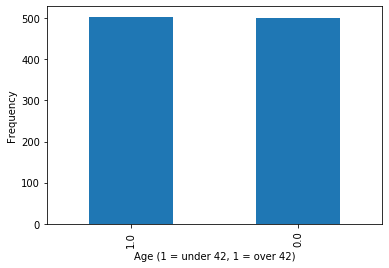

In [ ]:
df['age'].value_counts().plot(kind='bar')
plt.xlabel("Age (1 = under 42, 1 = over 42)")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

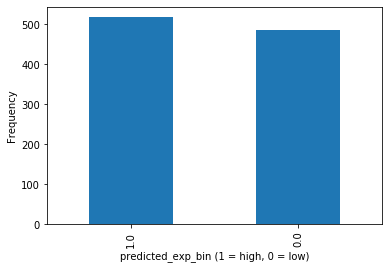

In [ ]:
df['predicted_exp_bin'].value_counts().plot(kind='bar')
plt.xlabel("predicted_exp_bin (1 = high, 0 = low)")
plt.ylabel("Frequency")

In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(
     dataset_orig_train, 
     unprivileged_groups=unprivileged_groups,
     privileged_groups=privileged_groups
  )
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.589336


In [ ]:
print("Original training dataset")
print("Disparate Impact = %f" % metric_orig_train.disparate_impact())

Original training dataset
Disparate Impact = 0.241852


In [ ]:
json_expl = MetricJSONExplainer(metric_orig_train)
def format_json(json_str):
    return json.dumps(json.loads(json_str, object_pairs_hook=OrderedDict),
                      indent=2)

print(format_json(json_expl.mean_difference()))

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): -0.5893359840954275",
  "numPositivesUnprivileged": 94.0,
  "numInstancesUnprivileged": 500.0,
  "numPositivesPrivileged": 391.0,
  "numInstancesPrivileged": 503.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}


In [ ]:
print(format_json(json_expl.disparate_impact()))

{
  "metric": "Disparate Impact",
  "message": "Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.24185166240409206",
  "numPositivePredictionsUnprivileged": 94.0,
  "numUnprivileged": 500.0,
  "numPositivePredictionsPrivileged": 391.0,
  "numPrivileged": 503.0,
  "description": "Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.",
  "ideal": "The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group."
}


In [ ]:
orig_aif360 = StandardDataset(df_train_encoded_actual, protected_attribute_names=['age'],
                             privileged_classes=[lambda x: x <= 39],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )
preds_aif360 = StandardDataset(df_train_encoded_pred, protected_attribute_names=['age'],
                             privileged_classes=[lambda x: x <= 39],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )

In [ ]:
orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_metrics.error_rate_difference())


print("\nFalse negative rate for privileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_metrics.false_negative_rate_ratio())


print("\nFalse positive rate for privileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_metrics.false_positive_rate_ratio())





Error rate difference (unprivileged error rate - privileged error rate)= 0.108429

False negative rate for privileged groups = 0.000000
False negative rate for unprivileged groups = 0.488372
False negative rate ratio = inf

False positive rate for privileged groups = 0.243243
False positive rate for unprivileged groups = 0.018293
False positive rate ratio = 0.075203


C:\Users\ccpok\anaconda3\lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)


## Protected = Age on test dataset

In [ ]:
dataset_orig_test = StandardDataset(df_test_encoded, protected_attribute_names=['age'],
                             privileged_classes=[lambda x: x <= 39],
                             label_name='predicted_exp_bin',
                             favorable_classes=[0]
                             )

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]


print("Original one hot encoded dataset shape: ",dataset_orig_test.features.shape)
print("Test dataset shape: ", dataset_orig_test.features.shape)

Original one hot encoded dataset shape:  (335, 9)
Test dataset shape:  (335, 9)


In [ ]:
df, dict_df = dataset_orig_test.convert_to_dataframe()

In [ ]:
print("Shape: ", df.shape)
print(df.columns)
df.head(5)

Shape:  (335, 10)
Index(['predicted_expenses', 'age', 'sex', 'bmi', 'children', 'smoker',
       'region', 'expenses', 'exp_bin', 'predicted_exp_bin'],
      dtype='object')


,predicted_expenses,age,sex,bmi,children,smoker,region,expenses,exp_bin,predicted_exp_bin
578,12357.302348,0.0,0.0,30.2,1.0,0.0,0.0,9724.53,0.0,1.0
610,11108.180880,0.0,1.0,29.4,1.0,0.0,1.0,8547.69,0.0,1.0
569,44799.296455,0.0,0.0,40.6,2.0,1.0,2.0,45702.02,1.0,1.0
1034,14000.362862,0.0,0.0,38.4,0.0,0.0,2.0,12950.07,1.0,1.0
198,11034.566241,0.0,1.0,18.1,0.0,0.0,2.0,9644.25,0.0,1.0


Text(0, 0.5, 'Frequency')

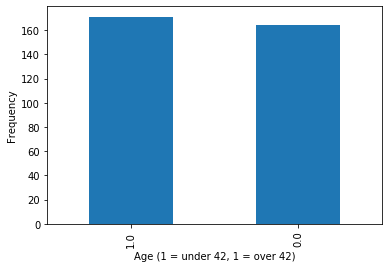

In [ ]:
df['age'].value_counts().plot(kind='bar')
plt.xlabel("Age (1 = under 42, 1 = over 42)")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

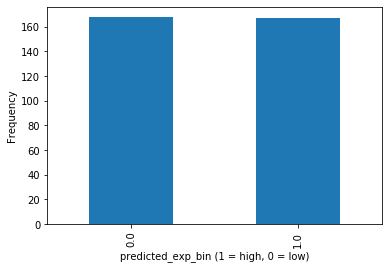

In [ ]:
df['predicted_exp_bin'].value_counts().plot(kind='bar')
plt.xlabel("predicted_exp_bin (1 = high, 0 = low)")
plt.ylabel("Frequency")

In [ ]:
metric_orig_test = BinaryLabelDatasetMetric(
     dataset_orig_test, 
     unprivileged_groups=unprivileged_groups,
     privileged_groups=privileged_groups
  )
print("Original test dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

Original test dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.636036


In [ ]:
print("Original test dataset")
print("Disparate Impact = %f" % metric_orig_test.disparate_impact())

Original test dataset
Disparate Impact = 0.217538


In [ ]:
json_expl = MetricJSONExplainer(metric_orig_test)
def format_json(json_str):
    return json.dumps(json.loads(json_str, object_pairs_hook=OrderedDict),
                      indent=2)

print(format_json(json_expl.mean_difference()))

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): -0.6360362287833405",
  "numPositivesUnprivileged": 29.0,
  "numInstancesUnprivileged": 164.0,
  "numPositivesPrivileged": 139.0,
  "numInstancesPrivileged": 171.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}


In [ ]:
print(format_json(json_expl.disparate_impact()))

{
  "metric": "Disparate Impact",
  "message": "Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.21753816459027897",
  "numPositivePredictionsUnprivileged": 29.0,
  "numUnprivileged": 164.0,
  "numPositivePredictionsPrivileged": 139.0,
  "numPrivileged": 171.0,
  "description": "Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.",
  "ideal": "The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group."
}


In [ ]:
orig_aif360 = StandardDataset(df_test_encoded_actual, protected_attribute_names=['age'],
                             privileged_classes=[lambda x: x <= 39],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )
preds_aif360 = StandardDataset(df_test_encoded_pred, protected_attribute_names=['age'],
                             privileged_classes=[lambda x: x <= 39],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )

In [ ]:
orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_metrics.error_rate_difference())


print("\nFalse negative rate for privileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_metrics.false_negative_rate_ratio())


print("\nFalse positive rate for privileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_metrics.false_positive_rate_ratio())





Error rate difference (unprivileged error rate - privileged error rate)= 0.118849

False negative rate for privileged groups = 0.000000
False negative rate for unprivileged groups = 0.517241
False negative rate ratio = inf

False positive rate for privileged groups = 0.272727
False positive rate for unprivileged groups = 0.009434
False positive rate ratio = 0.034591


## Protected = bmi on train dataset

In [ ]:
dataset_orig_train = StandardDataset(df_train_encoded, protected_attribute_names=['bmi'],
                             privileged_classes=[lambda x: x <= 30],
                             label_name='predicted_exp_bin',
                             favorable_classes=[0]
                             )

privileged_groups = [{'bmi': 1}]
unprivileged_groups = [{'bmi': 0}]


print("Original one hot encoded dataset shape: ",dataset_orig_train.features.shape)
print("Train dataset shape: ", dataset_orig_train.features.shape)

Original one hot encoded dataset shape:  (1003, 9)
Train dataset shape:  (1003, 9)


In [ ]:
df, dict_df = dataset_orig_train.convert_to_dataframe()

In [ ]:
print("Shape: ", df.shape)
print(df.columns)
df.head(5)

Shape:  (1003, 10)
Index(['predicted_expenses', 'age', 'sex', 'bmi', 'children', 'smoker',
       'region', 'expenses', 'exp_bin', 'predicted_exp_bin'],
      dtype='object')


,predicted_expenses,age,sex,bmi,children,smoker,region,expenses,exp_bin,predicted_exp_bin
1075,5933.590924,32.0,1.0,1.0,1.0,0.0,1.0,4562.84,0.0,0.0
131,14330.325440,61.0,1.0,1.0,0.0,0.0,3.0,13616.36,1.0,1.0
15,3412.916770,19.0,0.0,1.0,1.0,0.0,0.0,1837.24,0.0,0.0
1223,18239.599659,20.0,1.0,1.0,0.0,1.0,1.0,26125.67,1.0,1.0
1137,4366.878864,26.0,1.0,1.0,0.0,0.0,2.0,3176.29,0.0,0.0


In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(
     dataset_orig_train, 
     unprivileged_groups=unprivileged_groups,
     privileged_groups=privileged_groups
  )
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.077878


In [ ]:
print("Original training dataset")
print("Disparate Impact = %f" % metric_orig_train.disparate_impact())

Original training dataset
Disparate Impact = 0.851269


In [ ]:
json_expl = MetricJSONExplainer(metric_orig_train)
def format_json(json_str):
    return json.dumps(json.loads(json_str, object_pairs_hook=OrderedDict),
                      indent=2)

print(format_json(json_expl.mean_difference()))

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): -0.07787752893048727",
  "numPositivesUnprivileged": 230.0,
  "numInstancesUnprivileged": 516.0,
  "numPositivesPrivileged": 255.0,
  "numInstancesPrivileged": 487.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}


In [ ]:
print(format_json(json_expl.disparate_impact()))

{
  "metric": "Disparate Impact",
  "message": "Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.8512691898464811",
  "numPositivePredictionsUnprivileged": 230.0,
  "numUnprivileged": 516.0,
  "numPositivePredictionsPrivileged": 255.0,
  "numPrivileged": 487.0,
  "description": "Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.",
  "ideal": "The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group."
}


In [ ]:
orig_aif360 = StandardDataset(df_train_encoded_actual, protected_attribute_names=['bmi'],
                             privileged_classes=[lambda x: x <= 30],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )
preds_aif360 = StandardDataset(df_train_encoded_pred, protected_attribute_names=['bmi'],
                             privileged_classes=[lambda x: x <= 30],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )

In [ ]:
orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_metrics.error_rate_difference())


print("\nFalse negative rate for privileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_metrics.false_negative_rate_ratio())


print("\nFalse positive rate for privileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_metrics.false_positive_rate_ratio())





Error rate difference (unprivileged error rate - privileged error rate)= 0.020669

False negative rate for privileged groups = 0.138182
False negative rate for unprivileged groups = 0.182540
False negative rate ratio = 1.321011

False positive rate for privileged groups = 0.084906
False positive rate for unprivileged groups = 0.090909
False positive rate ratio = 1.070707


## Protected = Bmi on test dataset

In [ ]:
dataset_orig_test = StandardDataset(df_test_encoded, protected_attribute_names=['bmi'],
                             privileged_classes=[lambda x: x <= 30],
                             label_name='predicted_exp_bin',
                             favorable_classes=[0]
                             )

privileged_groups = [{'bmi': 1}]
unprivileged_groups = [{'bmi': 0}]


print("Original one hot encoded dataset shape: ",dataset_orig_test.features.shape)
print("Test dataset shape: ", dataset_orig_test.features.shape)

Original one hot encoded dataset shape:  (335, 9)
Test dataset shape:  (335, 9)


In [ ]:
df, dict_df = dataset_orig_test.convert_to_dataframe()

In [ ]:
print("Shape: ", df.shape)
print(df.columns)
df.head(5)

Shape:  (335, 10)
Index(['predicted_expenses', 'age', 'sex', 'bmi', 'children', 'smoker',
       'region', 'expenses', 'exp_bin', 'predicted_exp_bin'],
      dtype='object')


,predicted_expenses,age,sex,bmi,children,smoker,region,expenses,exp_bin,predicted_exp_bin
578,12357.302348,52.0,0.0,0.0,1.0,0.0,0.0,9724.53,0.0,1.0
610,11108.180880,47.0,1.0,1.0,1.0,0.0,1.0,8547.69,0.0,1.0
569,44799.296455,48.0,0.0,0.0,2.0,1.0,2.0,45702.02,1.0,1.0
1034,14000.362862,61.0,0.0,0.0,0.0,0.0,2.0,12950.07,1.0,1.0
198,11034.566241,51.0,1.0,1.0,0.0,0.0,2.0,9644.25,0.0,1.0


In [ ]:
metric_orig_test = BinaryLabelDatasetMetric(
     dataset_orig_test, 
     unprivileged_groups=unprivileged_groups,
     privileged_groups=privileged_groups
  )
print("Original test dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

Original test dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.015298


In [ ]:
print("Original test dataset")
print("Disparate Impact = %f" % metric_orig_test.disparate_impact())

Original test dataset
Disparate Impact = 0.969992


In [ ]:
json_expl = MetricJSONExplainer(metric_orig_test)
def format_json(json_str):
    return json.dumps(json.loads(json_str, object_pairs_hook=OrderedDict),
                      indent=2)

print(format_json(json_expl.mean_difference()))

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): -0.015298427063132891",
  "numPositivesUnprivileged": 90.0,
  "numInstancesUnprivileged": 182.0,
  "numPositivesPrivileged": 78.0,
  "numInstancesPrivileged": 153.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}


In [ ]:
print(format_json(json_expl.disparate_impact()))

{
  "metric": "Disparate Impact",
  "message": "Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.969991546914624",
  "numPositivePredictionsUnprivileged": 90.0,
  "numUnprivileged": 182.0,
  "numPositivePredictionsPrivileged": 78.0,
  "numPrivileged": 153.0,
  "description": "Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.",
  "ideal": "The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group."
}


In [ ]:
orig_aif360 = StandardDataset(df_test_encoded_actual, protected_attribute_names=['bmi'],
                             privileged_classes=[lambda x: x <= 30],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )
preds_aif360 = StandardDataset(df_test_encoded_pred, protected_attribute_names=['bmi'],
                             privileged_classes=[lambda x: x <= 30],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )

In [ ]:
orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_metrics.error_rate_difference())


print("\nFalse negative rate for privileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_metrics.false_negative_rate_ratio())


print("\nFalse positive rate for privileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_metrics.false_positive_rate_ratio())





Error rate difference (unprivileged error rate - privileged error rate)= -0.052467

False negative rate for privileged groups = 0.193182
False negative rate for unprivileged groups = 0.134021
False negative rate ratio = 0.693754

False positive rate for privileged groups = 0.107692
False positive rate for unprivileged groups = 0.070588
False positive rate ratio = 0.655462


## Protected = Smoker on training dataset

In [ ]:
dataset_orig_train = StandardDataset(df_train_encoded, protected_attribute_names=['smoker'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='predicted_exp_bin',
                             favorable_classes=[0]
                             )

privileged_groups = [{'smoker': 1}]
unprivileged_groups = [{'smoker': 0}]


print("Original one hot encoded dataset shape: ",dataset_orig_train.features.shape)
print("Train dataset shape: ", dataset_orig_train.features.shape)

Original one hot encoded dataset shape:  (1003, 9)
Train dataset shape:  (1003, 9)


In [ ]:
df, dict_df = dataset_orig_train.convert_to_dataframe()

In [ ]:
print("Shape: ", df.shape)
print(df.columns)
df.head(5)

Shape:  (1003, 10)
Index(['predicted_expenses', 'age', 'sex', 'bmi', 'children', 'smoker',
       'region', 'expenses', 'exp_bin', 'predicted_exp_bin'],
      dtype='object')


,predicted_expenses,age,sex,bmi,children,smoker,region,expenses,exp_bin,predicted_exp_bin
1075,5933.590924,32.0,1.0,29.6,1.0,1.0,1.0,4562.84,0.0,0.0
131,14330.325440,61.0,1.0,22.0,0.0,1.0,3.0,13616.36,1.0,1.0
15,3412.916770,19.0,0.0,24.6,1.0,1.0,0.0,1837.24,0.0,0.0
1223,18239.599659,20.0,1.0,24.4,0.0,0.0,1.0,26125.67,1.0,1.0
1137,4366.878864,26.0,1.0,22.2,0.0,1.0,2.0,3176.29,0.0,0.0


In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(
     dataset_orig_train, 
     unprivileged_groups=unprivileged_groups,
     privileged_groups=privileged_groups
  )
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.606250


In [ ]:
print("Original training dataset")
print("Disparate Impact = %f" % metric_orig_train.disparate_impact())

Original training dataset
Disparate Impact = 0.000000


In [ ]:
json_expl = MetricJSONExplainer(metric_orig_train)
def format_json(json_str):
    return json.dumps(json.loads(json_str, object_pairs_hook=OrderedDict),
                      indent=2)

print(format_json(json_expl.mean_difference()))

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): -0.60625",
  "numPositivesUnprivileged": 0.0,
  "numInstancesUnprivileged": 203.0,
  "numPositivesPrivileged": 485.0,
  "numInstancesPrivileged": 800.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}


In [ ]:
print(format_json(json_expl.disparate_impact()))

{
  "metric": "Disparate Impact",
  "message": "Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.0",
  "numPositivePredictionsUnprivileged": 0.0,
  "numUnprivileged": 203.0,
  "numPositivePredictionsPrivileged": 485.0,
  "numPrivileged": 800.0,
  "description": "Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.",
  "ideal": "The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group."
}


In [ ]:
orig_aif360 = StandardDataset(df_train_encoded_actual, protected_attribute_names=['smoker'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )
preds_aif360 = StandardDataset(df_train_encoded_pred, protected_attribute_names=['smoker'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )

In [ ]:
orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_metrics.error_rate_difference())


print("\nFalse negative rate for privileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_metrics.false_negative_rate_ratio())


print("\nFalse positive rate for privileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_metrics.false_positive_rate_ratio())





Error rate difference (unprivileged error rate - privileged error rate)= -0.157500

False negative rate for privileged groups = 0.159393
False negative rate for unprivileged groups = nan
False negative rate ratio = nan

False positive rate for privileged groups = 0.153846
False positive rate for unprivileged groups = 0.000000
False positive rate ratio = 0.000000


C:\Users\ccpok\anaconda3\lib\site-packages\aif360\metrics\classification_metric.py:264: RuntimeWarning: invalid value encountered in double_scalars
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
C:\Users\ccpok\anaconda3\lib\site-packages\aif360\metrics\classification_metric.py:265: RuntimeWarning: invalid value encountered in double_scalars
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


## Protected = Smoker on test dataset

In [ ]:
dataset_orig_test = StandardDataset(df_test_encoded, protected_attribute_names=['smoker'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='predicted_exp_bin',
                             favorable_classes=[0]
                             )

privileged_groups = [{'smoker': 1}]
unprivileged_groups = [{'smoker': 0}]


print("Original one hot encoded dataset shape: ",dataset_orig_test.features.shape)
print("test dataset shape: ", dataset_orig_test.features.shape)

Original one hot encoded dataset shape:  (335, 9)
test dataset shape:  (335, 9)


In [ ]:
df, dict_df = dataset_orig_test.convert_to_dataframe()
print("Shape: ", df.shape)
print(df.columns)
df.head(5)

Shape:  (335, 10)
Index(['predicted_expenses', 'age', 'sex', 'bmi', 'children', 'smoker',
       'region', 'expenses', 'exp_bin', 'predicted_exp_bin'],
      dtype='object')


,predicted_expenses,age,sex,bmi,children,smoker,region,expenses,exp_bin,predicted_exp_bin
578,12357.302348,52.0,0.0,30.2,1.0,0.0,0.0,9724.53,0.0,1.0
610,11108.180880,47.0,1.0,29.4,1.0,0.0,1.0,8547.69,0.0,1.0
569,44799.296455,48.0,0.0,40.6,2.0,1.0,2.0,45702.02,1.0,1.0
1034,14000.362862,61.0,0.0,38.4,0.0,0.0,2.0,12950.07,1.0,1.0
198,11034.566241,51.0,1.0,18.1,0.0,0.0,2.0,9644.25,0.0,1.0


In [ ]:
metric_orig_test = BinaryLabelDatasetMetric(
     dataset_orig_test, 
     unprivileged_groups=unprivileged_groups,
     privileged_groups=privileged_groups
  )
print("Original test dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

Original test dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.636364


In [ ]:
print("Original test dataset")
print("Disparate Impact = %f" % metric_orig_test.disparate_impact())

Original test dataset
Disparate Impact = 0.000000


In [ ]:
json_expl = MetricJSONExplainer(metric_orig_test)
def format_json(json_str):
    return json.dumps(json.loads(json_str, object_pairs_hook=OrderedDict),
                      indent=2)

print(format_json(json_expl.mean_difference()))

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): -0.6363636363636364",
  "numPositivesUnprivileged": 0.0,
  "numInstancesUnprivileged": 71.0,
  "numPositivesPrivileged": 168.0,
  "numInstancesPrivileged": 264.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}


In [ ]:
print(format_json(json_expl.disparate_impact()))

{
  "metric": "Disparate Impact",
  "message": "Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.0",
  "numPositivePredictionsUnprivileged": 0.0,
  "numUnprivileged": 71.0,
  "numPositivePredictionsPrivileged": 168.0,
  "numPrivileged": 264.0,
  "description": "Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.",
  "ideal": "The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group."
}


In [ ]:
orig_aif360 = StandardDataset(df_test_encoded_actual, protected_attribute_names=['smoker'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )
preds_aif360 = StandardDataset(df_test_encoded_pred, protected_attribute_names=['smoker'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )

In [ ]:
orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_metrics.error_rate_difference())


print("\nFalse negative rate for privileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_metrics.false_negative_rate_ratio())


print("\nFalse positive rate for privileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_metrics.false_positive_rate_ratio())





Error rate difference (unprivileged error rate - privileged error rate)= -0.162879

False negative rate for privileged groups = 0.162162
False negative rate for unprivileged groups = nan
False negative rate ratio = nan

False positive rate for privileged groups = 0.164557
False positive rate for unprivileged groups = 0.000000
False positive rate ratio = 0.000000


## Protected = Sex on training dataset

In [ ]:
dataset_orig_train = StandardDataset(df_train_encoded, protected_attribute_names=['sex'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='predicted_exp_bin',
                             favorable_classes=[0]
                             )

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]


print("Original one hot encoded dataset shape: ",dataset_orig_train.features.shape)
print("Train dataset shape: ", dataset_orig_train.features.shape)

Original one hot encoded dataset shape:  (1003, 9)
Train dataset shape:  (1003, 9)


In [ ]:
df, dict_df = dataset_orig_train.convert_to_dataframe()
print("Shape: ", df.shape)
print(df.columns)
df.head(5)

Shape:  (1003, 10)
Index(['predicted_expenses', 'age', 'sex', 'bmi', 'children', 'smoker',
       'region', 'expenses', 'exp_bin', 'predicted_exp_bin'],
      dtype='object')


,predicted_expenses,age,sex,bmi,children,smoker,region,expenses,exp_bin,predicted_exp_bin
1075,5933.590924,32.0,0.0,29.6,1.0,0.0,1.0,4562.84,0.0,0.0
131,14330.325440,61.0,0.0,22.0,0.0,0.0,3.0,13616.36,1.0,1.0
15,3412.916770,19.0,1.0,24.6,1.0,0.0,0.0,1837.24,0.0,0.0
1223,18239.599659,20.0,0.0,24.4,0.0,1.0,1.0,26125.67,1.0,1.0
1137,4366.878864,26.0,0.0,22.2,0.0,0.0,2.0,3176.29,0.0,0.0


In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(
     dataset_orig_train, 
     unprivileged_groups=unprivileged_groups,
     privileged_groups=privileged_groups
  )
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = 0.023428


In [ ]:
print("Original training dataset")
print("Disparate Impact = %f" % metric_orig_train.disparate_impact())

Original training dataset
Disparate Impact = 1.049672


In [ ]:
json_expl = MetricJSONExplainer(metric_orig_train)
def format_json(json_str):
    return json.dumps(json.loads(json_str, object_pairs_hook=OrderedDict),
                      indent=2)

print(format_json(json_expl.mean_difference()))

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): 0.0234284896160607",
  "numPositivesUnprivileged": 252.0,
  "numInstancesUnprivileged": 509.0,
  "numPositivesPrivileged": 233.0,
  "numInstancesPrivileged": 494.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}


In [ ]:
print(format_json(json_expl.disparate_impact()))

{
  "metric": "Disparate Impact",
  "message": "Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.049672420044352",
  "numPositivePredictionsUnprivileged": 252.0,
  "numUnprivileged": 509.0,
  "numPositivePredictionsPrivileged": 233.0,
  "numPrivileged": 494.0,
  "description": "Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.",
  "ideal": "The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group."
}


In [ ]:
orig_aif360 = StandardDataset(df_train_encoded_actual, protected_attribute_names=['sex'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )
preds_aif360 = StandardDataset(df_train_encoded_pred, protected_attribute_names=['sex'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )

In [ ]:
orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_metrics.error_rate_difference())


print("\nFalse negative rate for privileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_metrics.false_negative_rate_ratio())


print("\nFalse positive rate for privileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_metrics.false_positive_rate_ratio())





Error rate difference (unprivileged error rate - privileged error rate)= 0.000231

False negative rate for privileged groups = 0.156627
False negative rate for unprivileged groups = 0.161871
False negative rate ratio = 1.033481

False positive rate for privileged groups = 0.093878
False positive rate for unprivileged groups = 0.082251
False positive rate ratio = 0.876153


## Protected = Sex on test dataset

In [ ]:
dataset_orig_test = StandardDataset(df_test_encoded, protected_attribute_names=['sex'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='predicted_exp_bin',
                             favorable_classes=[0]
                             )

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]


print("Original one hot encoded dataset shape: ",dataset_orig_test.features.shape)
print("Train dataset shape: ", dataset_orig_test.features.shape)

Original one hot encoded dataset shape:  (335, 9)
Train dataset shape:  (335, 9)


In [ ]:
df, dict_df = dataset_orig_test.convert_to_dataframe()
print("Shape: ", df.shape)
print(df.columns)
df.head(5)

Shape:  (335, 10)
Index(['predicted_expenses', 'age', 'sex', 'bmi', 'children', 'smoker',
       'region', 'expenses', 'exp_bin', 'predicted_exp_bin'],
      dtype='object')


,predicted_expenses,age,sex,bmi,children,smoker,region,expenses,exp_bin,predicted_exp_bin
578,12357.302348,52.0,1.0,30.2,1.0,0.0,0.0,9724.53,0.0,1.0
610,11108.180880,47.0,0.0,29.4,1.0,0.0,1.0,8547.69,0.0,1.0
569,44799.296455,48.0,1.0,40.6,2.0,1.0,2.0,45702.02,1.0,1.0
1034,14000.362862,61.0,1.0,38.4,0.0,0.0,2.0,12950.07,1.0,1.0
198,11034.566241,51.0,0.0,18.1,0.0,0.0,2.0,9644.25,0.0,1.0


In [ ]:
metric_orig_test = BinaryLabelDatasetMetric(
     dataset_orig_test, 
     unprivileged_groups=unprivileged_groups,
     privileged_groups=privileged_groups
  )
print("Original test dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

Original test dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.020793


In [ ]:
print("Original test dataset")
print("Disparate Impact = %f" % metric_orig_test.disparate_impact())

Original test dataset
Disparate Impact = 0.959308


In [ ]:
json_expl = MetricJSONExplainer(metric_orig_test)
def format_json(json_str):
    return json.dumps(json.loads(json_str, object_pairs_hook=OrderedDict),
                      indent=2)

print(format_json(json_expl.mean_difference()))

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): -0.02079293255763842",
  "numPositivesUnprivileged": 75.0,
  "numInstancesUnprivileged": 153.0,
  "numPositivesPrivileged": 93.0,
  "numInstancesPrivileged": 182.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}


In [ ]:
print(format_json(json_expl.disparate_impact()))

{
  "metric": "Disparate Impact",
  "message": "Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9593084545646215",
  "numPositivePredictionsUnprivileged": 75.0,
  "numUnprivileged": 153.0,
  "numPositivePredictionsPrivileged": 93.0,
  "numPrivileged": 182.0,
  "description": "Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group.",
  "ideal": "The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group."
}


In [ ]:
orig_aif360 = StandardDataset(df_test_encoded_actual, protected_attribute_names=['sex'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )
preds_aif360 = StandardDataset(df_test_encoded_pred, protected_attribute_names=['sex'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )

In [ ]:
orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_metrics.error_rate_difference())


print("\nFalse negative rate for privileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_metrics.false_negative_rate_ratio())


print("\nFalse positive rate for privileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_metrics.false_positive_rate_ratio())





Error rate difference (unprivileged error rate - privileged error rate)= -0.019716

False negative rate for privileged groups = 0.185185
False negative rate for unprivileged groups = 0.129870
False negative rate ratio = 0.701299

False positive rate for privileged groups = 0.067568
False positive rate for unprivileged groups = 0.105263
False positive rate ratio = 1.557895


## Protected = Children on training dataset

In [ ]:
dataset_orig_train = StandardDataset(df_train_encoded, protected_attribute_names=['children'],
                             privileged_classes=[lambda x: x < 2],
                             label_name='predicted_exp_bin',
                             favorable_classes=[0]
                             )

privileged_groups = [{'children': 1}]
unprivileged_groups = [{'children': 0}]


print("Original one hot encoded dataset shape: ",dataset_orig_train.features.shape)
print("Train dataset shape: ", dataset_orig_train.features.shape)

Original one hot encoded dataset shape:  (1003, 9)
Train dataset shape:  (1003, 9)


In [ ]:
df, dict_df = dataset_orig_train.convert_to_dataframe()
print("Shape: ", df.shape)
print(df.columns)
df.head(5)

Shape:  (1003, 10)
Index(['predicted_expenses', 'age', 'sex', 'bmi', 'children', 'smoker',
       'region', 'expenses', 'exp_bin', 'predicted_exp_bin'],
      dtype='object')


,predicted_expenses,age,sex,bmi,children,smoker,region,expenses,exp_bin,predicted_exp_bin
1075,5933.590924,32.0,1.0,29.6,1.0,0.0,1.0,4562.84,0.0,0.0
131,14330.325440,61.0,1.0,22.0,1.0,0.0,3.0,13616.36,1.0,1.0
15,3412.916770,19.0,0.0,24.6,1.0,0.0,0.0,1837.24,0.0,0.0
1223,18239.599659,20.0,1.0,24.4,1.0,1.0,1.0,26125.67,1.0,1.0
1137,4366.878864,26.0,1.0,22.2,1.0,0.0,2.0,3176.29,0.0,0.0


In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(
     dataset_orig_train, 
     unprivileged_groups=unprivileged_groups,
     privileged_groups=privileged_groups
  )
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.034969


In [ ]:
print("Original training dataset")
print("Disparate Impact = %f" % metric_orig_train.disparate_impact())

Original training dataset
Disparate Impact = 0.929334


In [ ]:
orig_aif360 = StandardDataset(df_train_encoded_actual, protected_attribute_names=['children'],
                             privileged_classes=[lambda x: x < 2],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )
preds_aif360 = StandardDataset(df_train_encoded_pred, protected_attribute_names=['children'],
                             privileged_classes=[lambda x: x < 2],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )

In [ ]:
orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_metrics.error_rate_difference())


print("\nFalse negative rate for privileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_metrics.false_negative_rate_ratio())


print("\nFalse positive rate for privileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_metrics.false_positive_rate_ratio())





Error rate difference (unprivileged error rate - privileged error rate)= -0.035114

False negative rate for privileged groups = 0.174263
False negative rate for unprivileged groups = 0.123377
False negative rate ratio = 0.707992

False positive rate for privileged groups = 0.091503
False positive rate for unprivileged groups = 0.082353
False positive rate ratio = 0.900000


## Protected = Children on test dataset

In [ ]:
dataset_orig_test = StandardDataset(df_test_encoded, protected_attribute_names=['children'],
                             privileged_classes=[lambda x: x < 2],
                             label_name='predicted_exp_bin',
                             favorable_classes=[0]
                             )

privileged_groups = [{'children': 1}]
unprivileged_groups = [{'children': 0}]


print("Original one hot encoded dataset shape: ",dataset_orig_test.features.shape)
print("Train dataset shape: ", dataset_orig_test.features.shape)

Original one hot encoded dataset shape:  (335, 9)
Train dataset shape:  (335, 9)


In [ ]:
df, dict_df = dataset_orig_test.convert_to_dataframe()
print("Shape: ", df.shape)
print(df.columns)
df.head(5)

Shape:  (335, 10)
Index(['predicted_expenses', 'age', 'sex', 'bmi', 'children', 'smoker',
       'region', 'expenses', 'exp_bin', 'predicted_exp_bin'],
      dtype='object')


,predicted_expenses,age,sex,bmi,children,smoker,region,expenses,exp_bin,predicted_exp_bin
578,12357.302348,52.0,0.0,30.2,1.0,0.0,0.0,9724.53,0.0,1.0
610,11108.180880,47.0,1.0,29.4,1.0,0.0,1.0,8547.69,0.0,1.0
569,44799.296455,48.0,0.0,40.6,0.0,1.0,2.0,45702.02,1.0,1.0
1034,14000.362862,61.0,0.0,38.4,1.0,0.0,2.0,12950.07,1.0,1.0
198,11034.566241,51.0,1.0,18.1,1.0,0.0,2.0,9644.25,0.0,1.0


In [ ]:
metric_orig_test = BinaryLabelDatasetMetric(
     dataset_orig_test, 
     unprivileged_groups=unprivileged_groups,
     privileged_groups=privileged_groups
  )
print("Original test dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

Original test dataset
Difference in mean outcomes between unprivileged and privileged groups = 0.090025


In [ ]:
print("Original test dataset")
print("Disparate Impact = %f" % metric_orig_test.disparate_impact())

Original test dataset
Disparate Impact = 1.191413


In [ ]:
orig_aif360 = StandardDataset(df_test_encoded_actual, protected_attribute_names=['children'],
                             privileged_classes=[lambda x: x < 2],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )
preds_aif360 = StandardDataset(df_test_encoded_pred, protected_attribute_names=['children'],
                             privileged_classes=[lambda x: x < 2],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )

In [ ]:
orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_metrics.error_rate_difference())


print("\nFalse negative rate for privileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_metrics.false_negative_rate_ratio())


print("\nFalse positive rate for privileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_metrics.false_positive_rate_ratio())





Error rate difference (unprivileged error rate - privileged error rate)= 0.014643

False negative rate for privileged groups = 0.183333
False negative rate for unprivileged groups = 0.123077
False negative rate ratio = 0.671329

False positive rate for privileged groups = 0.050505
False positive rate for unprivileged groups = 0.156863
False positive rate ratio = 3.105882


## Protected = Region on training dataset

In [ ]:
dataset_orig_train = StandardDataset(df_train_encoded, protected_attribute_names=['region'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='predicted_exp_bin',
                             favorable_classes=[0]
                             )

privileged_groups = [{'region': 1}]
unprivileged_groups = [{'region': 0}]


print("Original one hot encoded dataset shape: ",dataset_orig_train.features.shape)
print("Train dataset shape: ", dataset_orig_train.features.shape)

Original one hot encoded dataset shape:  (1003, 9)
Train dataset shape:  (1003, 9)


In [ ]:
df, dict_df = dataset_orig_train.convert_to_dataframe()
print("Shape: ", df.shape)
print(df.columns)
df.head(5)

Shape:  (1003, 10)
Index(['predicted_expenses', 'age', 'sex', 'bmi', 'children', 'smoker',
       'region', 'expenses', 'exp_bin', 'predicted_exp_bin'],
      dtype='object')


,predicted_expenses,age,sex,bmi,children,smoker,region,expenses,exp_bin,predicted_exp_bin
1075,5933.590924,32.0,1.0,29.6,1.0,0.0,0.0,4562.84,0.0,0.0
131,14330.325440,61.0,1.0,22.0,0.0,0.0,0.0,13616.36,1.0,1.0
15,3412.916770,19.0,0.0,24.6,1.0,0.0,1.0,1837.24,0.0,0.0
1223,18239.599659,20.0,1.0,24.4,0.0,1.0,0.0,26125.67,1.0,1.0
1137,4366.878864,26.0,1.0,22.2,0.0,0.0,0.0,3176.29,0.0,0.0


In [ ]:
metric_orig_train = BinaryLabelDatasetMetric(
     dataset_orig_train, 
     unprivileged_groups=unprivileged_groups,
     privileged_groups=privileged_groups
  )
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.014469


In [ ]:
print("Original training dataset")
print("Disparate Impact = %f" % metric_orig_train.disparate_impact())

Original training dataset
Disparate Impact = 0.970727


In [ ]:
orig_aif360 = StandardDataset(df_train_encoded_actual, protected_attribute_names=['region'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )
preds_aif360 = StandardDataset(df_train_encoded_pred, protected_attribute_names=['region'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )

In [ ]:
orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_metrics.error_rate_difference())


print("\nFalse negative rate for privileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_metrics.false_negative_rate_ratio())


print("\nFalse positive rate for privileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_metrics.false_positive_rate_ratio())





Error rate difference (unprivileged error rate - privileged error rate)= -0.011458

False negative rate for privileged groups = 0.182432
False negative rate for unprivileged groups = 0.150396
False negative rate ratio = 0.824392

False positive rate for privileged groups = 0.070796
False positive rate for unprivileged groups = 0.093664
False positive rate ratio = 1.323003


## Protected = Region on test dataset

In [ ]:
dataset_orig_test = StandardDataset(df_test_encoded, protected_attribute_names=['region'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='predicted_exp_bin',
                             favorable_classes=[0]
                             )

privileged_groups = [{'region': 1}]
unprivileged_groups = [{'region': 0}]


print("Original one hot encoded dataset shape: ",dataset_orig_test.features.shape)
print("Train dataset shape: ", dataset_orig_test.features.shape)

Original one hot encoded dataset shape:  (335, 9)
Train dataset shape:  (335, 9)


In [ ]:
df, dict_df = dataset_orig_test.convert_to_dataframe()
print("Shape: ", df.shape)
print(df.columns)
df.head(5)

Shape:  (335, 10)
Index(['predicted_expenses', 'age', 'sex', 'bmi', 'children', 'smoker',
       'region', 'expenses', 'exp_bin', 'predicted_exp_bin'],
      dtype='object')


,predicted_expenses,age,sex,bmi,children,smoker,region,expenses,exp_bin,predicted_exp_bin
578,12357.302348,52.0,0.0,30.2,1.0,0.0,1.0,9724.53,0.0,1.0
610,11108.180880,47.0,1.0,29.4,1.0,0.0,0.0,8547.69,0.0,1.0
569,44799.296455,48.0,0.0,40.6,2.0,1.0,0.0,45702.02,1.0,1.0
1034,14000.362862,61.0,0.0,38.4,0.0,0.0,0.0,12950.07,1.0,1.0
198,11034.566241,51.0,1.0,18.1,0.0,0.0,0.0,9644.25,0.0,1.0


In [ ]:
metric_orig_test = BinaryLabelDatasetMetric(
     dataset_orig_test, 
     unprivileged_groups=unprivileged_groups,
     privileged_groups=privileged_groups
  )
print("Original test dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

Original test dataset
Difference in mean outcomes between unprivileged and privileged groups = 0.098420


In [ ]:
print("Original training dataset")
print("Disparate Impact = %f" % metric_orig_test.disparate_impact())

Original training dataset
Disparate Impact = 1.233292


In [ ]:
orig_aif360 = StandardDataset(df_test_encoded_actual, protected_attribute_names=['region'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )
preds_aif360 = StandardDataset(df_test_encoded_pred, protected_attribute_names=['region'],
                             privileged_classes=[lambda x: x == 0],
                             label_name='exp_bin',
                             favorable_classes=[0]
                             )

In [ ]:
orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_metrics.error_rate_difference())


print("\nFalse negative rate for privileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_metrics.false_negative_rate_ratio())


print("\nFalse positive rate for privileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivileged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_metrics.false_positive_rate_ratio())





Error rate difference (unprivileged error rate - privileged error rate)= -0.015164

False negative rate for privileged groups = 0.235294
False negative rate for unprivileged groups = 0.145695
False negative rate ratio = 0.619205

False positive rate for privileged groups = 0.033333
False positive rate for unprivileged groups = 0.100000
False positive rate ratio = 3.000000


# plot aif360 across subgroups

In [ ]:
train_meandiff = [-0.589336, -0.077878, -0.020793, 0.023428, -0.606250, -0.014469]
test_meandiff = [-0.636036, -0.015298, 0.090025, -0.020793, -0.636364, 0.098420]
train_dip_impact = [0.241852, 0.851269, 0.929334, 1.049672, 0.0, 0.970727]
test_dip_impact = [0.217538, 0.969992, 1.191413, 0.959308, 0.0, 1.233292]
train_error_diff = [0.108429, 0.020669, -0.035114, 0.000231, -0.157500, -0.011458]
test_error_diff = [0.118849, -0.052467, 0.014643, -0.019716, -0.162879, -0.015164]

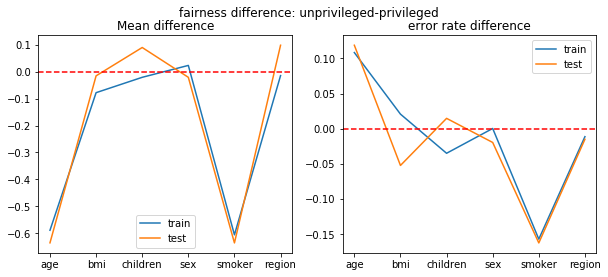

In [ ]:
fig, axe = plt.subplots(1,2,figsize=(10,4))

plt.suptitle("fairness difference: unprivileged-privileged")
x = ['age','bmi','children','sex','smoker','region']

axe[0].plot(x, train_meandiff, label='train')
axe[0].plot(x, test_meandiff, label='test')
axe[0].legend()
axe[0].set(title='Mean difference')
axe[0].axhline(y=0, color='r', linestyle='--')

axe[1].plot(x, train_error_diff, label='train')
axe[1].plot(x, test_error_diff, label='test')
axe[1].legend()
axe[1].set(title='error rate difference')
axe[1].axhline(y=0, color='r', linestyle='--')


C:\Users\ccpok\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


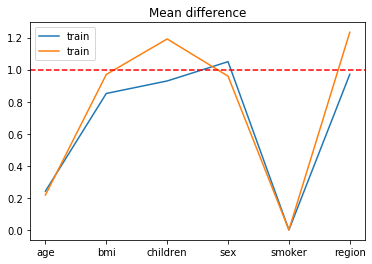

In [ ]:
plt.plot(x, train_dip_impact, label='train')
plt.plot(x, test_dip_impact, label='train')
plt.legend()
plt.title('Mean difference')
plt.axhline(y=1, color='r', linestyle='--')
plt.show()

A negative value below the dotted line means that the unprivileged group has lower metric value than the privileged group.

A positive value above the dotted line means that the unprivileged group has higher metric value than the privileged group.